Global seed set to 0
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/matplotlib_inline/config.py:54: DeprecationWarning: InlineBackend._print_figure_kwargs_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _upd

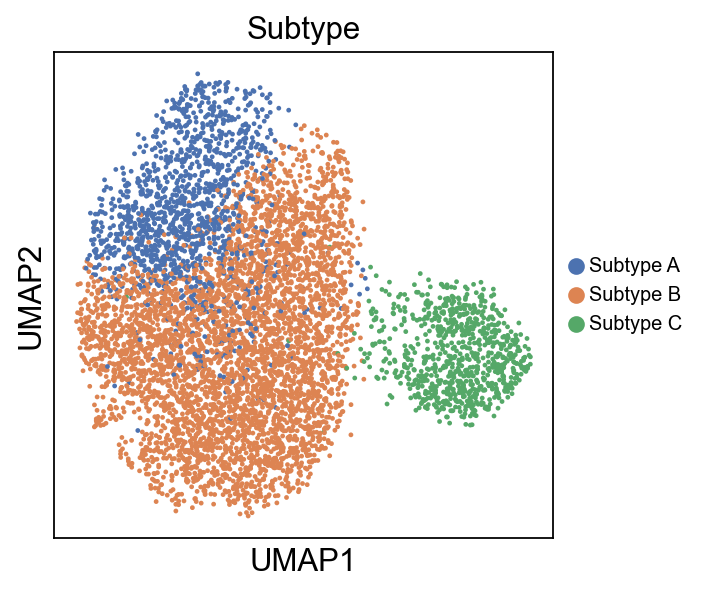

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


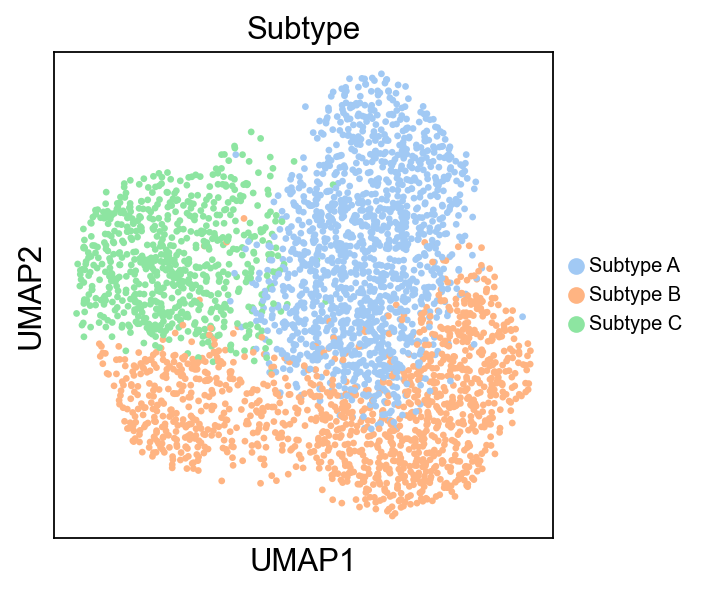

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:91: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:91: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [1]:
#from scarches.dataset.trvae.data_handling import remove_sparsity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import scanpy as sc
from scvi.model.utils import mde
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import scvi
import fsspec
import scvi
import scvelo as scv
import h5py
import anndata
import pandas as pd
import network
import numpy as np
import networkx
import desc 
import umap
import seaborn as sns
import scib
import torch
#import scarches as sca
import gdown
import pymde
import muon



%matplotlib inline 
%load_ext rpy2.ipython
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
sc.settings.verbosity = 3 
sc.set_figure_params(figsize=(4, 4))


# Reading in the adata file from the subtype data
adata_152 = scv.read("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS152/OS152_adata_subtype_PCA.h5ad")


# Plotting the umap based on subtype
sc.pl.umap(adata_152, color=['Subtype'], legend_fontsize=9)


# Setting keys
cell_type_key = 'Subtype'


# Reading in the adata file from the subtype data
adata_384 = scv.read("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384/OS384_PCA_subtype.h5ad")


# Plotting OS384 umap based on subtype       
sc.pl.umap(adata_384, color=['Subtype'], legend_fontsize=9)


# Making a gene list for OS384
OS384_var_names = list(adata_384.var.index.values)


# Remove duplicated from list 
OS384_genes = [] 
for i in OS384_var_names: 
    if i not in OS384_genes: 
        OS384_genes.append(i) 
        
        
# Making a list of 152 genes
OS152_genes = list(adata_152.var.index.values)


# Python program to illustrate the intersection
# of two lists using set() method
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))
 
    
# Identiyfing the common genes within these samples
common_genes = intersection(OS384_genes, OS152_genes)


# Filtering 152 for the common genes
muon.pp.filter_var(adata_152, common_genes)


# Filtering OS384 for the common genes
muon.pp.filter_var(adata_384, common_genes)


# Setting up the anndata object to include continuous covariate variables
scvi.model.SCVI.setup_anndata(
    adata_152,
    layer="counts",
    continuous_covariate_keys=["pct_counts_mt", "ccdifference"]
)


# Setting up the anndata object to include continuous covariate variables
scvi.model.SCVI.setup_anndata(
    adata_384,
    layer="counts",
    continuous_covariate_keys=["pct_counts_mt", "ccdifference"]
)

# OS152 to OS384

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/400:   0%|                                      | 0/400 [00:00<?, ?it/s]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 2/400:   0%|           | 1/400 [00:00<05:33,  1.20it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 3/400:   0%|           | 2/400 [00:01<04:56,  1.34it/s, loss=380, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 4/400:   1%|           | 3/400 [00:02<04:40,  1.41it/s, loss=376, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 5/400:   1%|           | 4/400 [00:02<04:32,  1.45it/s, loss=373, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 6/400:   1%|▏          | 5/400 [00:03<04:25,  1.49it/s, loss=371, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 7/400:   2%|▏          | 6/400 [00:04<04:19,  1.52it/s, loss=368, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 8/400:   2%|▏          | 7/400 [00:04<04:17,  1.53it/s, loss=367, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 9/400:   2%|▏          | 8/400 [00:05<04:22,  1.49it/s, loss=364, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 10/400:   2%|▏         | 9/400 [00:06<04:39,  1.40it/s, loss=363, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 11/400:   2%|▏        | 10/400 [00:07<04:42,  1.38it/s, loss=361, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 12/400:   3%|▏        | 11/400 [00:07<04:40,  1.39it/s, loss=359, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 13/400:   3%|▎        | 12/400 [00:08<04:53,  1.32it/s, loss=356, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 14/400:   3%|▎        | 13/400 [00:09<04:45,  1.36it/s, loss=356, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 15/400:   4%|▎        | 14/400 [00:09<04:33,  1.41it/s, loss=354, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 16/400:   4%|▎        | 15/400 [00:10<04:26,  1.44it/s, loss=353, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 17/400:   4%|▎        | 16/400 [00:11<04:20,  1.47it/s, loss=353, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 18/400:   4%|▍        | 17/400 [00:11<04:14,  1.51it/s, loss=350, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 19/400:   4%|▍        | 18/400 [00:12<04:12,  1.51it/s, loss=349, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 20/400:   5%|▍        | 19/400 [00:13<04:08,  1.53it/s, loss=348, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 21/400:   5%|▍        | 20/400 [00:13<04:11,  1.51it/s, loss=346, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 22/400:   5%|▍        | 21/400 [00:14<04:09,  1.52it/s, loss=345, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 23/400:   6%|▍        | 22/400 [00:15<04:18,  1.46it/s, loss=345, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 24/400:   6%|▌        | 23/400 [00:15<04:23,  1.43it/s, loss=343, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 25/400:   6%|▌        | 24/400 [00:17<05:35,  1.12it/s, loss=343, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 26/400:   6%|▌        | 25/400 [00:18<05:45,  1.09it/s, loss=342, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 27/400:   6%|▌        | 26/400 [00:19<05:31,  1.13it/s, loss=342, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 28/400:   7%|▌        | 27/400 [00:20<05:35,  1.11it/s, loss=340, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 29/400:   7%|▋        | 28/400 [00:20<05:07,  1.21it/s, loss=340, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 30/400:   7%|▋        | 29/400 [00:21<04:44,  1.30it/s, loss=339, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 31/400:   8%|▋        | 30/400 [00:21<04:29,  1.37it/s, loss=337, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 32/400:   8%|▋        | 31/400 [00:22<04:17,  1.43it/s, loss=337, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 33/400:   8%|▋        | 32/400 [00:23<04:09,  1.47it/s, loss=337, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 34/400:   8%|▋        | 33/400 [00:23<04:05,  1.50it/s, loss=336, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 35/400:   8%|▊        | 34/400 [00:24<04:00,  1.52it/s, loss=335, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 36/400:   9%|▊        | 35/400 [00:25<03:55,  1.55it/s, loss=335, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 37/400:   9%|▊        | 36/400 [00:25<03:53,  1.56it/s, loss=334, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 38/400:   9%|▊        | 37/400 [00:26<03:51,  1.57it/s, loss=332, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 39/400:  10%|▊        | 38/400 [00:26<03:47,  1.59it/s, loss=333, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 40/400:  10%|▉        | 39/400 [00:27<03:54,  1.54it/s, loss=332, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 41/400:  10%|▉        | 40/400 [00:28<04:01,  1.49it/s, loss=332, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 42/400:  10%|▉        | 41/400 [00:29<03:56,  1.52it/s, loss=331, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 43/400:  10%|▉        | 42/400 [00:29<03:50,  1.55it/s, loss=330, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 44/400:  11%|▉        | 43/400 [00:30<03:48,  1.56it/s, loss=330, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 45/400:  11%|▉        | 44/400 [00:30<03:45,  1.58it/s, loss=330, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 46/400:  11%|█        | 45/400 [00:31<03:44,  1.58it/s, loss=328, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 47/400:  12%|█        | 46/400 [00:32<03:42,  1.59it/s, loss=328, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 48/400:  12%|█        | 47/400 [00:32<03:41,  1.59it/s, loss=329, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 49/400:  12%|█        | 48/400 [00:33<03:40,  1.59it/s, loss=327, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 50/400:  12%|█        | 49/400 [00:33<03:39,  1.60it/s, loss=327, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 51/400:  12%|█▏       | 50/400 [00:34<03:38,  1.60it/s, loss=326, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 52/400:  13%|█▏       | 51/400 [00:35<03:36,  1.61it/s, loss=327, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 53/400:  13%|█▏       | 52/400 [00:35<03:36,  1.61it/s, loss=327, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 54/400:  13%|█▏       | 53/400 [00:36<03:34,  1.62it/s, loss=324, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 55/400:  14%|█▏       | 54/400 [00:37<03:49,  1.51it/s, loss=326, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 56/400:  14%|█▏       | 55/400 [00:37<03:44,  1.54it/s, loss=325, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 57/400:  14%|█▎       | 56/400 [00:38<03:39,  1.57it/s, loss=324, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 58/400:  14%|█▎       | 57/400 [00:39<03:38,  1.57it/s, loss=324, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 59/400:  14%|█▎       | 58/400 [00:39<03:35,  1.58it/s, loss=323, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 60/400:  15%|█▎       | 59/400 [00:40<03:35,  1.58it/s, loss=323, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 61/400:  15%|█▎       | 60/400 [00:40<03:35,  1.58it/s, loss=324, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 62/400:  15%|█▎       | 61/400 [00:41<03:33,  1.58it/s, loss=322, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 63/400:  16%|█▍       | 62/400 [00:42<03:31,  1.60it/s, loss=323, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 64/400:  16%|█▍       | 63/400 [00:42<03:30,  1.60it/s, loss=323, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 65/400:  16%|█▍       | 64/400 [00:43<03:28,  1.61it/s, loss=323, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 66/400:  16%|█▍       | 65/400 [00:44<03:27,  1.61it/s, loss=322, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 67/400:  16%|█▍       | 66/400 [00:44<03:25,  1.63it/s, loss=321, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 68/400:  17%|█▌       | 67/400 [00:45<03:24,  1.63it/s, loss=321, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 69/400:  17%|█▌       | 68/400 [00:45<03:22,  1.64it/s, loss=321, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 70/400:  17%|█▌       | 69/400 [00:46<03:21,  1.64it/s, loss=320, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 71/400:  18%|█▌       | 70/400 [00:47<03:21,  1.64it/s, loss=320, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 72/400:  18%|█▌       | 71/400 [00:47<03:20,  1.64it/s, loss=320, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 73/400:  18%|█▌       | 72/400 [00:48<03:19,  1.64it/s, loss=320, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 74/400:  18%|█▋       | 73/400 [00:48<03:19,  1.64it/s, loss=319, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 75/400:  18%|█▋       | 74/400 [00:49<03:18,  1.64it/s, loss=320, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 76/400:  19%|█▋       | 75/400 [00:50<03:17,  1.65it/s, loss=320, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 77/400:  19%|█▋       | 76/400 [00:50<03:38,  1.49it/s, loss=319, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 78/400:  19%|█▋       | 77/400 [00:51<03:31,  1.53it/s, loss=319, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 79/400:  20%|█▊       | 78/400 [00:52<03:26,  1.56it/s, loss=319, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 80/400:  20%|█▊       | 79/400 [00:52<03:21,  1.59it/s, loss=319, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 81/400:  20%|█▊       | 80/400 [00:53<03:19,  1.61it/s, loss=319, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 82/400:  20%|█▊       | 81/400 [00:54<03:18,  1.61it/s, loss=319, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 83/400:  20%|█▊       | 82/400 [00:54<03:17,  1.61it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 84/400:  21%|█▊       | 83/400 [00:55<03:15,  1.62it/s, loss=318, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 85/400:  21%|█▉       | 84/400 [00:55<03:13,  1.63it/s, loss=318, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 86/400:  21%|█▉       | 85/400 [00:56<03:12,  1.64it/s, loss=318, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 87/400:  22%|█▉       | 86/400 [00:57<03:10,  1.64it/s, loss=318, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 88/400:  22%|█▉       | 87/400 [00:57<03:10,  1.64it/s, loss=318, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 89/400:  22%|█▉       | 88/400 [00:58<03:09,  1.65it/s, loss=318, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 90/400:  22%|██       | 89/400 [00:58<03:08,  1.65it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 91/400:  22%|██       | 90/400 [00:59<03:07,  1.66it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 92/400:  23%|██       | 91/400 [01:00<03:06,  1.66it/s, loss=318, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 93/400:  23%|██       | 92/400 [01:00<03:05,  1.66it/s, loss=318, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 94/400:  23%|██       | 93/400 [01:01<03:04,  1.66it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 95/400:  24%|██       | 94/400 [01:01<03:04,  1.66it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 96/400:  24%|██▏      | 95/400 [01:02<03:03,  1.66it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 97/400:  24%|██▏      | 96/400 [01:03<03:02,  1.66it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 98/400:  24%|██▏      | 97/400 [01:03<03:02,  1.66it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 99/400:  24%|██▏      | 98/400 [01:04<03:01,  1.67it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 100/400:  25%|█▉      | 99/400 [01:04<03:00,  1.67it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 101/400:  25%|█▊     | 100/400 [01:05<02:59,  1.67it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 102/400:  25%|█▊     | 101/400 [01:06<02:59,  1.67it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 103/400:  26%|█▊     | 102/400 [01:06<02:59,  1.66it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 104/400:  26%|█▊     | 103/400 [01:07<02:58,  1.66it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 105/400:  26%|█▊     | 104/400 [01:07<02:57,  1.67it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 106/400:  26%|█▊     | 105/400 [01:08<02:57,  1.66it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 107/400:  26%|█▊     | 106/400 [01:09<02:56,  1.66it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 108/400:  27%|█▊     | 107/400 [01:09<02:55,  1.67it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 109/400:  27%|█▉     | 108/400 [01:10<02:54,  1.67it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 110/400:  27%|█▉     | 109/400 [01:10<02:54,  1.66it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 111/400:  28%|█▉     | 110/400 [01:11<02:53,  1.67it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 112/400:  28%|█▉     | 111/400 [01:12<02:53,  1.67it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 113/400:  28%|█▉     | 112/400 [01:12<02:52,  1.67it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 114/400:  28%|█▉     | 113/400 [01:13<02:51,  1.67it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 115/400:  28%|█▉     | 114/400 [01:13<02:50,  1.67it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 116/400:  29%|██     | 115/400 [01:14<02:50,  1.67it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 117/400:  29%|██     | 116/400 [01:15<02:49,  1.67it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 118/400:  29%|██     | 117/400 [01:15<02:49,  1.67it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 119/400:  30%|██     | 118/400 [01:16<02:48,  1.68it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 120/400:  30%|██     | 119/400 [01:16<02:47,  1.68it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 121/400:  30%|██     | 120/400 [01:17<02:46,  1.68it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 122/400:  30%|██     | 121/400 [01:18<02:47,  1.67it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 123/400:  30%|██▏    | 122/400 [01:18<02:46,  1.67it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 124/400:  31%|██▏    | 123/400 [01:19<02:45,  1.67it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 125/400:  31%|██▏    | 124/400 [01:19<02:44,  1.67it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 126/400:  31%|██▏    | 125/400 [01:20<02:49,  1.62it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 127/400:  32%|██▏    | 126/400 [01:21<02:54,  1.57it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 128/400:  32%|██▏    | 127/400 [01:21<02:53,  1.58it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 129/400:  32%|██▏    | 128/400 [01:22<02:49,  1.60it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 130/400:  32%|██▎    | 129/400 [01:23<02:52,  1.57it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 131/400:  32%|██▎    | 130/400 [01:23<02:57,  1.52it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 132/400:  33%|██▎    | 131/400 [01:24<02:54,  1.54it/s, loss=314, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 133/400:  33%|██▎    | 132/400 [01:25<02:52,  1.55it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 134/400:  33%|██▎    | 133/400 [01:25<02:55,  1.52it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 135/400:  34%|██▎    | 134/400 [01:26<03:00,  1.47it/s, loss=314, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 136/400:  34%|██▎    | 135/400 [01:27<02:58,  1.49it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 137/400:  34%|██▍    | 136/400 [01:27<02:51,  1.54it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 138/400:  34%|██▍    | 137/400 [01:28<02:45,  1.59it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 139/400:  34%|██▍    | 138/400 [01:28<02:42,  1.62it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 140/400:  35%|██▍    | 139/400 [01:29<02:38,  1.64it/s, loss=314, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 141/400:  35%|██▍    | 140/400 [01:30<02:36,  1.66it/s, loss=314, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 142/400:  35%|██▍    | 141/400 [01:30<02:34,  1.67it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 143/400:  36%|██▍    | 142/400 [01:31<02:33,  1.68it/s, loss=313, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 144/400:  36%|██▌    | 143/400 [01:31<02:32,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 145/400:  36%|██▌    | 144/400 [01:32<02:31,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 146/400:  36%|██▌    | 145/400 [01:33<02:30,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 147/400:  36%|██▌    | 146/400 [01:33<02:29,  1.70it/s, loss=314, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 148/400:  37%|██▌    | 147/400 [01:34<02:28,  1.70it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 149/400:  37%|██▌    | 148/400 [01:34<02:28,  1.70it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 150/400:  37%|██▌    | 149/400 [01:35<02:26,  1.71it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 151/400:  38%|██▋    | 150/400 [01:35<02:26,  1.71it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 152/400:  38%|██▋    | 151/400 [01:36<02:25,  1.71it/s, loss=314, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 153/400:  38%|██▋    | 152/400 [01:37<02:28,  1.67it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 154/400:  38%|██▋    | 153/400 [01:37<02:27,  1.68it/s, loss=314, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 155/400:  38%|██▋    | 154/400 [01:38<02:26,  1.68it/s, loss=314, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 156/400:  39%|██▋    | 155/400 [01:39<02:32,  1.61it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 157/400:  39%|██▋    | 156/400 [01:39<02:31,  1.61it/s, loss=314, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 158/400:  39%|██▋    | 157/400 [01:40<02:29,  1.63it/s, loss=314, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 159/400:  40%|██▊    | 158/400 [01:40<02:27,  1.64it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 160/400:  40%|██▊    | 159/400 [01:41<02:24,  1.66it/s, loss=314, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 161/400:  40%|██▊    | 160/400 [01:41<02:23,  1.67it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 162/400:  40%|██▊    | 161/400 [01:42<02:22,  1.68it/s, loss=314, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 163/400:  40%|██▊    | 162/400 [01:43<02:21,  1.68it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 164/400:  41%|██▊    | 163/400 [01:43<02:20,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 165/400:  41%|██▊    | 164/400 [01:44<02:20,  1.69it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 166/400:  41%|██▉    | 165/400 [01:44<02:19,  1.68it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 167/400:  42%|██▉    | 166/400 [01:45<02:18,  1.68it/s, loss=314, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 168/400:  42%|██▉    | 167/400 [01:46<02:17,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 169/400:  42%|██▉    | 168/400 [01:46<02:17,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 170/400:  42%|██▉    | 169/400 [01:47<02:16,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 171/400:  42%|██▉    | 170/400 [01:47<02:16,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 172/400:  43%|██▉    | 171/400 [01:48<02:15,  1.69it/s, loss=314, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 173/400:  43%|███    | 172/400 [01:49<02:14,  1.69it/s, loss=314, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 174/400:  43%|███    | 173/400 [01:49<02:15,  1.68it/s, loss=314, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 175/400:  44%|███    | 174/400 [01:50<02:14,  1.68it/s, loss=314, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 176/400:  44%|███    | 175/400 [01:50<02:13,  1.68it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 177/400:  44%|███    | 176/400 [01:51<02:12,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 178/400:  44%|███    | 177/400 [01:52<02:12,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 179/400:  44%|███    | 178/400 [01:52<02:11,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 180/400:  45%|███▏   | 179/400 [01:53<02:10,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 181/400:  45%|███▏   | 180/400 [01:53<02:09,  1.70it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 182/400:  45%|███▏   | 181/400 [01:54<02:09,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 183/400:  46%|███▏   | 182/400 [01:55<02:09,  1.68it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 184/400:  46%|███▏   | 183/400 [01:55<02:08,  1.69it/s, loss=314, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 185/400:  46%|███▏   | 184/400 [01:56<02:07,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 186/400:  46%|███▏   | 185/400 [01:56<02:07,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 187/400:  46%|███▎   | 186/400 [01:57<02:06,  1.69it/s, loss=314, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 188/400:  47%|███▎   | 187/400 [01:57<02:05,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 189/400:  47%|███▎   | 188/400 [01:58<02:05,  1.70it/s, loss=314, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 190/400:  47%|███▎   | 189/400 [01:59<02:04,  1.69it/s, loss=314, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 191/400:  48%|███▎   | 190/400 [01:59<02:04,  1.69it/s, loss=314, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 192/400:  48%|███▎   | 191/400 [02:00<02:03,  1.69it/s, loss=314, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 193/400:  48%|███▎   | 192/400 [02:00<02:02,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 194/400:  48%|███▍   | 193/400 [02:01<02:02,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 195/400:  48%|███▍   | 194/400 [02:02<02:01,  1.69it/s, loss=314, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 196/400:  49%|███▍   | 195/400 [02:02<02:01,  1.69it/s, loss=314, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 197/400:  49%|███▍   | 196/400 [02:03<02:00,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 198/400:  49%|███▍   | 197/400 [02:03<01:59,  1.70it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 199/400:  50%|███▍   | 198/400 [02:04<01:59,  1.69it/s, loss=314, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 200/400:  50%|███▍   | 199/400 [02:05<01:58,  1.69it/s, loss=314, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 201/400:  50%|███▌   | 200/400 [02:05<01:58,  1.69it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 202/400:  50%|███▌   | 201/400 [02:06<01:57,  1.69it/s, loss=314, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 203/400:  50%|███▌   | 202/400 [02:06<01:57,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 204/400:  51%|███▌   | 203/400 [02:07<01:56,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 205/400:  51%|███▌   | 204/400 [02:08<01:56,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 206/400:  51%|███▌   | 205/400 [02:08<01:55,  1.68it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 207/400:  52%|███▌   | 206/400 [02:09<01:56,  1.67it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 208/400:  52%|███▌   | 207/400 [02:09<01:55,  1.68it/s, loss=314, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 209/400:  52%|███▋   | 208/400 [02:10<01:55,  1.66it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 210/400:  52%|███▋   | 209/400 [02:11<01:54,  1.66it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 211/400:  52%|███▋   | 210/400 [02:11<01:53,  1.68it/s, loss=314, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 212/400:  53%|███▋   | 211/400 [02:12<01:52,  1.68it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 213/400:  53%|███▋   | 212/400 [02:12<01:51,  1.69it/s, loss=314, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 214/400:  53%|███▋   | 213/400 [02:13<01:50,  1.69it/s, loss=314, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 215/400:  54%|███▋   | 214/400 [02:13<01:49,  1.69it/s, loss=314, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 216/400:  54%|███▊   | 215/400 [02:14<01:49,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 217/400:  54%|███▊   | 216/400 [02:15<01:48,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 218/400:  54%|███▊   | 217/400 [02:15<01:47,  1.69it/s, loss=314, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 219/400:  55%|███▊   | 218/400 [02:16<01:47,  1.70it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 220/400:  55%|███▊   | 219/400 [02:16<01:46,  1.70it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 221/400:  55%|███▊   | 220/400 [02:17<01:45,  1.70it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 222/400:  55%|███▊   | 221/400 [02:18<01:45,  1.70it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 223/400:  56%|███▉   | 222/400 [02:18<01:44,  1.70it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 224/400:  56%|███▉   | 223/400 [02:19<01:44,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 225/400:  56%|███▉   | 224/400 [02:19<01:44,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 226/400:  56%|███▉   | 225/400 [02:20<01:43,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 227/400:  56%|███▉   | 226/400 [02:21<01:42,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 228/400:  57%|███▉   | 227/400 [02:21<01:42,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 229/400:  57%|███▉   | 228/400 [02:22<01:41,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 230/400:  57%|████   | 229/400 [02:22<01:41,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 231/400:  57%|████   | 230/400 [02:23<01:45,  1.61it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 232/400:  58%|████   | 231/400 [02:24<01:45,  1.60it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 233/400:  58%|████   | 232/400 [02:24<01:43,  1.63it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 234/400:  58%|████   | 233/400 [02:25<01:41,  1.65it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 235/400:  58%|████   | 234/400 [02:25<01:39,  1.66it/s, loss=314, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 236/400:  59%|████   | 235/400 [02:26<01:38,  1.68it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 237/400:  59%|████▏  | 236/400 [02:27<01:37,  1.68it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 238/400:  59%|████▏  | 237/400 [02:27<01:36,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 239/400:  60%|████▏  | 238/400 [02:28<01:35,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 240/400:  60%|████▏  | 239/400 [02:28<01:34,  1.70it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 241/400:  60%|████▏  | 240/400 [02:29<01:34,  1.70it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 242/400:  60%|████▏  | 241/400 [02:30<01:34,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 243/400:  60%|████▏  | 242/400 [02:30<01:36,  1.64it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 244/400:  61%|████▎  | 243/400 [02:31<01:35,  1.65it/s, loss=314, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 245/400:  61%|████▎  | 244/400 [02:31<01:33,  1.67it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 246/400:  61%|████▎  | 245/400 [02:32<01:32,  1.68it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 247/400:  62%|████▎  | 246/400 [02:33<01:31,  1.68it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 248/400:  62%|████▎  | 247/400 [02:33<01:30,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 249/400:  62%|████▎  | 248/400 [02:34<01:29,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 250/400:  62%|████▎  | 249/400 [02:34<01:29,  1.69it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 251/400:  62%|████▍  | 250/400 [02:35<01:28,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 252/400:  63%|████▍  | 251/400 [02:36<01:27,  1.70it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 253/400:  63%|████▍  | 252/400 [02:36<01:27,  1.68it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 254/400:  63%|████▍  | 253/400 [02:37<01:27,  1.68it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 255/400:  64%|████▍  | 254/400 [02:37<01:26,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 256/400:  64%|████▍  | 255/400 [02:38<01:26,  1.69it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 257/400:  64%|████▍  | 256/400 [02:38<01:25,  1.69it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 258/400:  64%|████▍  | 257/400 [02:39<01:24,  1.69it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 259/400:  64%|████▌  | 258/400 [02:40<01:23,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 260/400:  65%|████▌  | 259/400 [02:40<01:24,  1.67it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 261/400:  65%|████▌  | 260/400 [02:41<01:25,  1.65it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 262/400:  65%|████▌  | 261/400 [02:42<01:24,  1.65it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 263/400:  66%|████▌  | 262/400 [02:42<01:22,  1.67it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 264/400:  66%|████▌  | 263/400 [02:43<01:21,  1.67it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 265/400:  66%|████▌  | 264/400 [02:43<01:21,  1.67it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 266/400:  66%|████▋  | 265/400 [02:44<01:20,  1.68it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 267/400:  66%|████▋  | 266/400 [02:44<01:19,  1.68it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 268/400:  67%|████▋  | 267/400 [02:45<01:19,  1.68it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 269/400:  67%|████▋  | 268/400 [02:46<01:18,  1.68it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 270/400:  67%|████▋  | 269/400 [02:46<01:17,  1.68it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 271/400:  68%|████▋  | 270/400 [02:47<01:17,  1.68it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 272/400:  68%|████▋  | 271/400 [02:47<01:16,  1.68it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 273/400:  68%|████▊  | 272/400 [02:48<01:16,  1.68it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 274/400:  68%|████▊  | 273/400 [02:49<01:15,  1.68it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 275/400:  68%|████▊  | 274/400 [02:49<01:14,  1.69it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 276/400:  69%|████▊  | 275/400 [02:50<01:14,  1.68it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 277/400:  69%|████▊  | 276/400 [02:50<01:13,  1.68it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 278/400:  69%|████▊  | 277/400 [02:51<01:13,  1.68it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 279/400:  70%|████▊  | 278/400 [02:52<01:12,  1.69it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 280/400:  70%|████▉  | 279/400 [02:52<01:11,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 281/400:  70%|████▉  | 280/400 [02:53<01:11,  1.69it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 282/400:  70%|████▉  | 281/400 [02:53<01:10,  1.68it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 283/400:  70%|████▉  | 282/400 [02:54<01:10,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 284/400:  71%|████▉  | 283/400 [02:55<01:10,  1.66it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 285/400:  71%|████▉  | 284/400 [02:55<01:09,  1.67it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 286/400:  71%|████▉  | 285/400 [02:56<01:08,  1.68it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 287/400:  72%|█████  | 286/400 [02:56<01:07,  1.69it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 288/400:  72%|█████  | 287/400 [02:57<01:06,  1.69it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 289/400:  72%|█████  | 288/400 [02:58<01:06,  1.69it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 290/400:  72%|█████  | 289/400 [02:58<01:05,  1.69it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 291/400:  72%|█████  | 290/400 [02:59<01:05,  1.69it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 292/400:  73%|█████  | 291/400 [02:59<01:05,  1.67it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 293/400:  73%|█████  | 292/400 [03:00<01:04,  1.68it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 294/400:  73%|█████▏ | 293/400 [03:01<01:03,  1.68it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 295/400:  74%|█████▏ | 294/400 [03:01<01:02,  1.69it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 296/400:  74%|█████▏ | 295/400 [03:02<01:02,  1.69it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 297/400:  74%|█████▏ | 296/400 [03:02<01:01,  1.69it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 298/400:  74%|█████▏ | 297/400 [03:03<01:00,  1.69it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 299/400:  74%|█████▏ | 298/400 [03:03<01:00,  1.69it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 300/400:  75%|█████▏ | 299/400 [03:04<00:59,  1.69it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 301/400:  75%|█████▎ | 300/400 [03:05<00:59,  1.69it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 302/400:  75%|█████▎ | 301/400 [03:05<00:58,  1.69it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 303/400:  76%|█████▎ | 302/400 [03:06<00:58,  1.69it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 304/400:  76%|█████▎ | 303/400 [03:06<00:58,  1.66it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 305/400:  76%|█████▎ | 304/400 [03:07<00:58,  1.64it/s, loss=315, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 306/400:  76%|█████▎ | 305/400 [03:08<00:58,  1.63it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 307/400:  76%|█████▎ | 306/400 [03:08<00:58,  1.61it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 308/400:  77%|█████▎ | 307/400 [03:09<00:58,  1.59it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 309/400:  77%|█████▍ | 308/400 [03:10<00:57,  1.61it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 310/400:  77%|█████▍ | 309/400 [03:10<00:55,  1.63it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 311/400:  78%|█████▍ | 310/400 [03:11<00:54,  1.65it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 312/400:  78%|█████▍ | 311/400 [03:11<00:53,  1.67it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 313/400:  78%|█████▍ | 312/400 [03:12<00:52,  1.67it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 314/400:  78%|█████▍ | 313/400 [03:13<00:51,  1.68it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 315/400:  78%|█████▍ | 314/400 [03:13<00:50,  1.69it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 316/400:  79%|█████▌ | 315/400 [03:14<00:50,  1.69it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 317/400:  79%|█████▌ | 316/400 [03:14<00:49,  1.69it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 318/400:  79%|█████▌ | 317/400 [03:15<00:49,  1.69it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 319/400:  80%|█████▌ | 318/400 [03:15<00:48,  1.68it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 320/400:  80%|█████▌ | 319/400 [03:16<00:47,  1.69it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 321/400:  80%|█████▌ | 320/400 [03:17<00:47,  1.67it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 322/400:  80%|█████▌ | 321/400 [03:17<00:47,  1.67it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 323/400:  80%|█████▋ | 322/400 [03:18<00:46,  1.67it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 324/400:  81%|█████▋ | 323/400 [03:19<00:46,  1.66it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 325/400:  81%|█████▋ | 324/400 [03:19<00:45,  1.66it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 326/400:  81%|█████▋ | 325/400 [03:20<00:44,  1.67it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 327/400:  82%|█████▋ | 326/400 [03:20<00:44,  1.68it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 328/400:  82%|█████▋ | 327/400 [03:21<00:43,  1.68it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 329/400:  82%|█████▋ | 328/400 [03:21<00:42,  1.69it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 330/400:  82%|█████▊ | 329/400 [03:22<00:41,  1.69it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 331/400:  82%|█████▊ | 330/400 [03:23<00:41,  1.69it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 332/400:  83%|█████▊ | 331/400 [03:23<00:40,  1.69it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 333/400:  83%|█████▊ | 332/400 [03:24<00:40,  1.70it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 334/400:  83%|█████▊ | 333/400 [03:25<00:56,  1.18it/s, loss=318, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 335/400:  84%|█████▊ | 334/400 [03:26<00:52,  1.25it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 336/400:  84%|█████▊ | 335/400 [03:27<00:49,  1.31it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 337/400:  84%|█████▉ | 336/400 [03:27<00:45,  1.39it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 338/400:  84%|█████▉ | 337/400 [03:28<00:42,  1.47it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 339/400:  84%|█████▉ | 338/400 [03:28<00:40,  1.54it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 340/400:  85%|█████▉ | 339/400 [03:29<00:38,  1.59it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 341/400:  85%|█████▉ | 340/400 [03:30<00:37,  1.62it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 342/400:  85%|█████▉ | 341/400 [03:30<00:35,  1.64it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 343/400:  86%|█████▉ | 342/400 [03:31<00:34,  1.66it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 344/400:  86%|██████ | 343/400 [03:31<00:34,  1.68it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 345/400:  86%|██████ | 344/400 [03:32<00:33,  1.69it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 346/400:  86%|██████ | 345/400 [03:33<00:32,  1.70it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 347/400:  86%|██████ | 346/400 [03:33<00:31,  1.71it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 348/400:  87%|██████ | 347/400 [03:34<00:30,  1.71it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 349/400:  87%|██████ | 348/400 [03:34<00:30,  1.72it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 350/400:  87%|██████ | 349/400 [03:35<00:29,  1.72it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 351/400:  88%|██████▏| 350/400 [03:35<00:29,  1.72it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 352/400:  88%|██████▏| 351/400 [03:36<00:28,  1.72it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 353/400:  88%|██████▏| 352/400 [03:37<00:29,  1.63it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 354/400:  88%|██████▏| 353/400 [03:37<00:28,  1.65it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 355/400:  88%|██████▏| 354/400 [03:38<00:27,  1.67it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 356/400:  89%|██████▏| 355/400 [03:38<00:26,  1.68it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 357/400:  89%|██████▏| 356/400 [03:39<00:26,  1.69it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 358/400:  89%|██████▏| 357/400 [03:40<00:25,  1.68it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 359/400:  90%|██████▎| 358/400 [03:40<00:24,  1.68it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 360/400:  90%|██████▎| 359/400 [03:41<00:24,  1.69it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 361/400:  90%|██████▎| 360/400 [03:41<00:23,  1.70it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 362/400:  90%|██████▎| 361/400 [03:42<00:22,  1.70it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 363/400:  90%|██████▎| 362/400 [03:43<00:22,  1.70it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 364/400:  91%|██████▎| 363/400 [03:43<00:21,  1.70it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 365/400:  91%|██████▎| 364/400 [03:44<00:21,  1.71it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 366/400:  91%|██████▍| 365/400 [03:44<00:20,  1.71it/s, loss=318, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 367/400:  92%|██████▍| 366/400 [03:45<00:19,  1.71it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 368/400:  92%|██████▍| 367/400 [03:45<00:19,  1.71it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 369/400:  92%|██████▍| 368/400 [03:46<00:18,  1.71it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 370/400:  92%|██████▍| 369/400 [03:47<00:18,  1.71it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 371/400:  92%|██████▍| 370/400 [03:47<00:17,  1.70it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 372/400:  93%|██████▍| 371/400 [03:48<00:17,  1.70it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 373/400:  93%|██████▌| 372/400 [03:48<00:16,  1.70it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 374/400:  93%|██████▌| 373/400 [03:49<00:15,  1.70it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 375/400:  94%|██████▌| 374/400 [03:50<00:15,  1.70it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 376/400:  94%|██████▌| 375/400 [03:50<00:14,  1.70it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 377/400:  94%|██████▌| 376/400 [03:51<00:14,  1.70it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 378/400:  94%|██████▌| 377/400 [03:51<00:13,  1.70it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 379/400:  94%|██████▌| 378/400 [03:52<00:13,  1.66it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 380/400:  95%|██████▋| 379/400 [03:53<00:13,  1.62it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 381/400:  95%|██████▋| 380/400 [03:53<00:12,  1.64it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 382/400:  95%|██████▋| 381/400 [03:54<00:11,  1.66it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 383/400:  96%|██████▋| 382/400 [03:54<00:10,  1.66it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 384/400:  96%|██████▋| 383/400 [03:55<00:10,  1.67it/s, loss=318, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 385/400:  96%|██████▋| 384/400 [03:56<00:09,  1.68it/s, loss=316, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 386/400:  96%|██████▋| 385/400 [03:56<00:08,  1.69it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 387/400:  96%|██████▊| 386/400 [03:57<00:08,  1.70it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 388/400:  97%|██████▊| 387/400 [03:57<00:07,  1.70it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 389/400:  97%|██████▊| 388/400 [03:58<00:07,  1.71it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 390/400:  97%|██████▊| 389/400 [03:59<00:06,  1.71it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 391/400:  98%|██████▊| 390/400 [03:59<00:05,  1.71it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 392/400:  98%|██████▊| 391/400 [04:00<00:05,  1.71it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 393/400:  98%|██████▊| 392/400 [04:00<00:04,  1.70it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 394/400:  98%|██████▉| 393/400 [04:01<00:04,  1.71it/s, loss=318, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 395/400:  98%|██████▉| 394/400 [04:01<00:03,  1.71it/s, loss=318, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 396/400:  99%|██████▉| 395/400 [04:02<00:02,  1.70it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 397/400:  99%|██████▉| 396/400 [04:03<00:02,  1.70it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 398/400:  99%|██████▉| 397/400 [04:03<00:01,  1.70it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 399/400: 100%|██████▉| 398/400 [04:04<00:01,  1.71it/s, loss=318, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 400/400: 100%|██████▉| 399/400 [04:04<00:00,  1.71it/s, loss=317, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 400/400: 100%|███████| 400/400 [04:05<00:00,  1.71it/s, loss=317, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|███████| 400/400 [04:05<00:00,  1.63it/s, loss=317, v_num=1]


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden_scVI', the cluster labels (adata.obs, categorical) (0:00:01)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


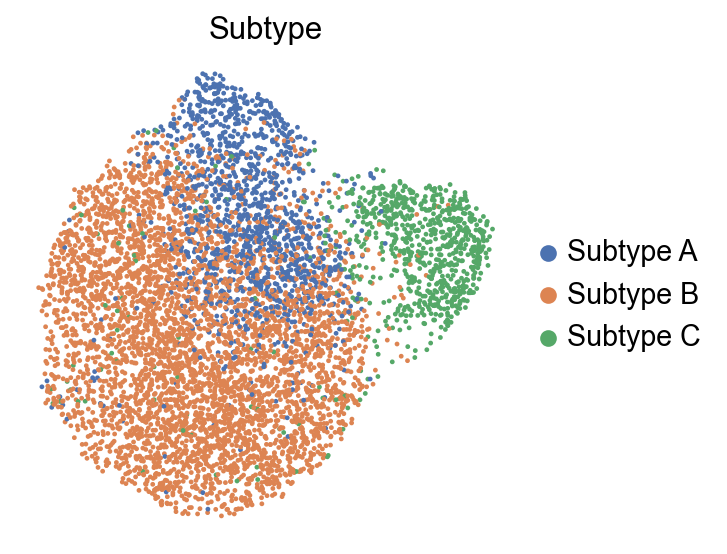

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:91: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


INFO     Training for 20 epochs.                                                                                   


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/20:   0%|                                        | 0/20 [00:00<?, ?it/s]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 2/20:   5%|▋            | 1/20 [00:01<00:28,  1.53s/it, loss=346, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 3/20:  10%|█▎           | 2/20 [00:02<00:24,  1.34s/it, loss=340, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 4/20:  15%|█▉           | 3/20 [00:04<00:23,  1.36s/it, loss=337, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 5/20:  20%|██▌          | 4/20 [00:05<00:23,  1.44s/it, loss=333, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 6/20:  25%|███▎         | 5/20 [00:06<00:20,  1.34s/it, loss=332, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 7/20:  30%|███▉         | 6/20 [00:08<00:18,  1.32s/it, loss=329, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 8/20:  35%|████▌        | 7/20 [00:09<00:16,  1.27s/it, loss=328, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 9/20:  40%|█████▏       | 8/20 [00:10<00:15,  1.26s/it, loss=327, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 10/20:  45%|█████▍      | 9/20 [00:11<00:14,  1.29s/it, loss=326, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 11/20:  50%|█████▌     | 10/20 [00:13<00:12,  1.25s/it, loss=325, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 12/20:  55%|██████     | 11/20 [00:14<00:11,  1.23s/it, loss=325, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 13/20:  60%|██████▌    | 12/20 [00:15<00:09,  1.20s/it, loss=325, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 14/20:  65%|███████▏   | 13/20 [00:16<00:08,  1.18s/it, loss=324, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 15/20:  70%|███████▋   | 14/20 [00:17<00:07,  1.18s/it, loss=325, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 16/20:  75%|████████▎  | 15/20 [00:19<00:06,  1.29s/it, loss=325, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 17/20:  80%|████████▊  | 16/20 [00:20<00:05,  1.29s/it, loss=325, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 18/20:  85%|█████████▎ | 17/20 [00:21<00:03,  1.25s/it, loss=325, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 19/20:  90%|█████████▉ | 18/20 [00:22<00:02,  1.22s/it, loss=325, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 20/20:  95%|██████████▍| 19/20 [00:24<00:01,  1.23s/it, loss=325, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 20/20: 100%|███████████| 20/20 [00:25<00:00,  1.27s/it, loss=325, v_num=1]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|███████████| 20/20 [00:25<00:00,  1.27s/it, loss=325, v_num=1]
computing neighbors


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


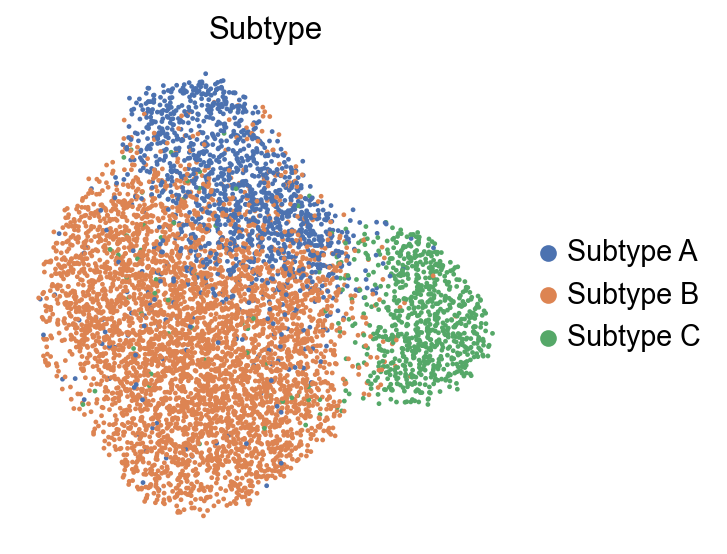

INFO     File OS152_model_scanvi_full_384/model.pt already downloaded                                              
INFO     Found 100.0% reference vars in query data.                                                                
INFO     File OS152_model_scanvi_full_384/model.pt already downloaded                                              


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:91: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


INFO     Training for 100 epochs.                                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/100:   0%|                                      | 0/100 [00:00<?, ?it/s]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 2/100:   1%|           | 1/100 [00:00<00:50,  1.96it/s, loss=528, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 3/100:   2%|▏          | 2/100 [00:01<00:50,  1.93it/s, loss=522, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 4/100:   3%|▎          | 3/100 [00:01<00:53,  1.81it/s, loss=517, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 5/100:   4%|▍          | 4/100 [00:02<00:50,  1.89it/s, loss=513, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 6/100:   5%|▌          | 5/100 [00:02<00:49,  1.92it/s, loss=509, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 7/100:   6%|▋          | 6/100 [00:03<00:48,  1.94it/s, loss=507, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 8/100:   7%|▊          | 7/100 [00:03<00:48,  1.91it/s, loss=504, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 9/100:   8%|▉          | 8/100 [00:04<00:47,  1.93it/s, loss=502, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 10/100:   9%|▉         | 9/100 [00:04<00:49,  1.83it/s, loss=500, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 11/100:  10%|▉        | 10/100 [00:05<00:49,  1.81it/s, loss=498, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 12/100:  11%|▉        | 11/100 [00:05<00:50,  1.76it/s, loss=497, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 13/100:  12%|█        | 12/100 [00:06<00:48,  1.81it/s, loss=496, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 14/100:  13%|█▏       | 13/100 [00:06<00:46,  1.86it/s, loss=493, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 15/100:  14%|█▎       | 14/100 [00:07<00:45,  1.90it/s, loss=492, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 16/100:  15%|█▎       | 15/100 [00:08<00:44,  1.89it/s, loss=492, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 17/100:  16%|█▍       | 16/100 [00:09<01:01,  1.36it/s, loss=491, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 18/100:  17%|█▌       | 17/100 [00:10<01:10,  1.17it/s, loss=489, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 19/100:  18%|█▌       | 18/100 [00:11<01:10,  1.16it/s, loss=489, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 20/100:  19%|█▋       | 19/100 [00:12<01:09,  1.16it/s, loss=489, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 21/100:  20%|█▊       | 20/100 [00:12<01:02,  1.27it/s, loss=487, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 22/100:  21%|█▉       | 21/100 [00:13<00:55,  1.43it/s, loss=487, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 23/100:  22%|█▉       | 22/100 [00:13<00:50,  1.55it/s, loss=486, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 24/100:  23%|██       | 23/100 [00:14<00:46,  1.67it/s, loss=486, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 25/100:  24%|██▏      | 24/100 [00:14<00:43,  1.75it/s, loss=485, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 26/100:  25%|██▎      | 25/100 [00:15<00:41,  1.82it/s, loss=485, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 27/100:  26%|██▎      | 26/100 [00:15<00:41,  1.79it/s, loss=485, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 28/100:  27%|██▍      | 27/100 [00:16<00:43,  1.69it/s, loss=485, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 29/100:  28%|██▌      | 28/100 [00:17<00:41,  1.74it/s, loss=484, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 30/100:  29%|██▌      | 29/100 [00:17<00:42,  1.69it/s, loss=483, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 31/100:  30%|██▋      | 30/100 [00:18<00:42,  1.64it/s, loss=483, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 32/100:  31%|██▊      | 31/100 [00:18<00:39,  1.73it/s, loss=483, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 33/100:  32%|██▉      | 32/100 [00:19<00:37,  1.80it/s, loss=483, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 34/100:  33%|██▉      | 33/100 [00:19<00:36,  1.81it/s, loss=483, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 35/100:  34%|███      | 34/100 [00:20<00:35,  1.86it/s, loss=483, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 36/100:  35%|███▏     | 35/100 [00:20<00:34,  1.89it/s, loss=482, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 37/100:  36%|███▏     | 36/100 [00:21<00:35,  1.83it/s, loss=483, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 38/100:  37%|███▎     | 37/100 [00:21<00:33,  1.86it/s, loss=482, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 39/100:  38%|███▍     | 38/100 [00:22<00:33,  1.85it/s, loss=482, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 40/100:  39%|███▌     | 39/100 [00:23<00:32,  1.89it/s, loss=482, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 41/100:  40%|███▌     | 40/100 [00:23<00:31,  1.88it/s, loss=481, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 42/100:  41%|███▋     | 41/100 [00:24<00:30,  1.91it/s, loss=481, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 43/100:  42%|███▊     | 42/100 [00:24<00:29,  1.95it/s, loss=481, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 44/100:  43%|███▊     | 43/100 [00:25<00:29,  1.96it/s, loss=481, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 45/100:  44%|███▉     | 44/100 [00:25<00:28,  1.97it/s, loss=481, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 46/100:  45%|████     | 45/100 [00:26<00:28,  1.96it/s, loss=481, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 47/100:  46%|████▏    | 46/100 [00:26<00:27,  1.95it/s, loss=481, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 48/100:  47%|████▏    | 47/100 [00:27<00:27,  1.94it/s, loss=481, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 49/100:  48%|████▎    | 48/100 [00:27<00:27,  1.92it/s, loss=481, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 50/100:  49%|████▍    | 49/100 [00:28<00:27,  1.88it/s, loss=481, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 51/100:  50%|████▌    | 50/100 [00:28<00:28,  1.77it/s, loss=481, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 52/100:  51%|████▌    | 51/100 [00:29<00:27,  1.79it/s, loss=481, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 53/100:  52%|████▋    | 52/100 [00:29<00:26,  1.78it/s, loss=481, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 54/100:  53%|████▊    | 53/100 [00:30<00:26,  1.74it/s, loss=481, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 55/100:  54%|████▊    | 54/100 [00:31<00:27,  1.68it/s, loss=481, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 56/100:  55%|████▉    | 55/100 [00:31<00:26,  1.71it/s, loss=481, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 57/100:  56%|█████    | 56/100 [00:32<00:25,  1.76it/s, loss=481, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 58/100:  57%|█████▏   | 57/100 [00:32<00:24,  1.73it/s, loss=481, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 59/100:  58%|█████▏   | 58/100 [00:33<00:23,  1.80it/s, loss=482, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 60/100:  59%|█████▎   | 59/100 [00:33<00:22,  1.84it/s, loss=481, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 61/100:  60%|█████▍   | 60/100 [00:34<00:21,  1.85it/s, loss=481, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 62/100:  61%|█████▍   | 61/100 [00:34<00:20,  1.89it/s, loss=482, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 63/100:  62%|█████▌   | 62/100 [00:35<00:19,  1.94it/s, loss=482, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 64/100:  63%|█████▋   | 63/100 [00:35<00:18,  1.96it/s, loss=481, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 65/100:  64%|█████▊   | 64/100 [00:36<00:18,  1.96it/s, loss=482, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 66/100:  65%|█████▊   | 65/100 [00:36<00:17,  1.98it/s, loss=482, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 67/100:  66%|█████▉   | 66/100 [00:37<00:17,  2.00it/s, loss=482, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 68/100:  67%|██████   | 67/100 [00:37<00:16,  1.99it/s, loss=482, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 69/100:  68%|██████   | 68/100 [00:38<00:15,  2.01it/s, loss=482, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 70/100:  69%|██████▏  | 69/100 [00:38<00:15,  2.01it/s, loss=482, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 71/100:  70%|██████▎  | 70/100 [00:39<00:15,  1.93it/s, loss=482, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 72/100:  71%|██████▍  | 71/100 [00:40<00:15,  1.92it/s, loss=482, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 73/100:  72%|██████▍  | 72/100 [00:40<00:14,  1.95it/s, loss=483, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 74/100:  73%|██████▌  | 73/100 [00:40<00:13,  1.98it/s, loss=482, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 75/100:  74%|██████▋  | 74/100 [00:41<00:13,  1.91it/s, loss=482, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 76/100:  75%|██████▊  | 75/100 [00:42<00:13,  1.84it/s, loss=483, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 77/100:  76%|██████▊  | 76/100 [00:42<00:12,  1.89it/s, loss=484, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 78/100:  77%|██████▉  | 77/100 [00:43<00:11,  1.93it/s, loss=483, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 79/100:  78%|███████  | 78/100 [00:43<00:11,  1.96it/s, loss=483, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 80/100:  79%|███████  | 79/100 [00:44<00:10,  1.99it/s, loss=484, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 81/100:  80%|███████▏ | 80/100 [00:44<00:10,  1.96it/s, loss=483, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 82/100:  81%|███████▎ | 81/100 [00:45<00:09,  1.99it/s, loss=483, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 83/100:  82%|███████▍ | 82/100 [00:45<00:08,  2.00it/s, loss=483, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 84/100:  83%|███████▍ | 83/100 [00:46<00:08,  2.02it/s, loss=484, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 85/100:  84%|███████▌ | 84/100 [00:46<00:07,  2.02it/s, loss=483, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 86/100:  85%|███████▋ | 85/100 [00:47<00:07,  2.03it/s, loss=484, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 87/100:  86%|███████▋ | 86/100 [00:47<00:06,  2.03it/s, loss=484, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 88/100:  87%|███████▊ | 87/100 [00:48<00:06,  2.03it/s, loss=485, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 89/100:  88%|███████▉ | 88/100 [00:48<00:05,  2.03it/s, loss=484, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 90/100:  89%|████████ | 89/100 [00:49<00:05,  2.04it/s, loss=484, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 91/100:  90%|████████ | 90/100 [00:49<00:05,  1.99it/s, loss=484, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 92/100:  91%|████████▏| 91/100 [00:50<00:04,  2.00it/s, loss=485, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 93/100:  92%|████████▎| 92/100 [00:50<00:03,  2.02it/s, loss=485, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 94/100:  93%|████████▎| 93/100 [00:51<00:03,  2.02it/s, loss=485, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 95/100:  94%|████████▍| 94/100 [00:51<00:02,  2.03it/s, loss=484, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 96/100:  95%|████████▌| 95/100 [00:52<00:02,  2.03it/s, loss=485, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 97/100:  96%|████████▋| 96/100 [00:52<00:01,  2.04it/s, loss=486, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 98/100:  97%|████████▋| 97/100 [00:53<00:01,  2.03it/s, loss=485, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 99/100:  98%|████████▊| 98/100 [00:53<00:00,  2.03it/s, loss=485, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 100/100:  99%|███████▉| 99/100 [00:53<00:00,  2.03it/s, loss=485, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 100/100: 100%|███████| 100/100 [00:54<00:00,  1.99it/s, loss=485, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|███████| 100/100 [00:54<00:00,  1.83it/s, loss=485, v_num=1]


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden_scVI', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


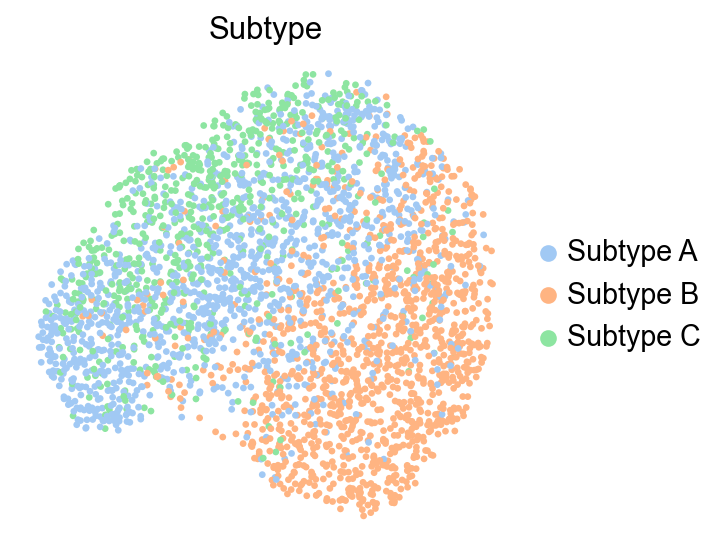

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


In [8]:
# setting up the scvi model
# is there a way to just import this model?
vae_152 = scvi.model.SCVI(adata_152, n_layers=2, n_latent=30, gene_likelihood="nb")


# Training the OS152 model
vae_152.train()


# Saving the normalized expression values
adata_152.layers["scvi_normalized"] = vae_152.get_normalized_expression(
    library_size=10e4
)


# Getting the latent representation
latent = vae_152.get_latent_representation()


# adding the latent variables to the adata object
adata_152.obsm["X_scVI"] = latent


# using the scVI latent space for umap generation
sc.pp.neighbors(adata_152, use_rep="X_scVI")
sc.tl.umap(adata_152, min_dist=0.3)


# clustering using the leiden algorithm
# neighbors were already computed using scVI
sc.tl.leiden(adata_152, key_added="leiden_scVI", resolution=0.58)


# plotting the clusters
sc.pl.umap(
    adata_152,
    color=["Subtype"],
    frameon=False,
)


# unlabeled category does not exist in adata.obs[labels_key]
# so all cells are treated as labeled
vae_ref_scan = scvi.model.SCANVI.from_scvi_model(
    vae_152,
    unlabeled_category= "Unknown",
    labels_key= "Subtype",
)


# training the reference model
vae_ref_scan.train(max_epochs=20, n_samples_per_label=100)


# saving the latent representation from the reference model
adata_152.obsm["X_scANVI"] = vae_ref_scan.get_latent_representation()
sc.pp.neighbors(adata_152, use_rep="X_scANVI")
sc.tl.leiden(adata_152)
sc.tl.umap(adata_152)


# Plotting the umap
sc.pl.umap(
    adata_152,
    color=["Subtype"],
    frameon=False,
    ncols=1,
)


dir_path_scan = "OS152_model_scanvi_full_384/"
vae_ref_scan.save(dir_path_scan, overwrite=True)


# preparing the query data
scvi.model.SCANVI.prepare_query_anndata(adata_384, dir_path_scan)


# loading the query data
vae_q = scvi.model.SCANVI.load_query_data(
    adata_384,
    dir_path_scan,
)


# Training the query model
vae_q.train(
    max_epochs=100,
    plan_kwargs=dict(weight_decay=0.0),
    check_val_every_n_epoch=10,
)


# getting the latent representation from the query model and saving it on the adata 384 dataset
adata_384.obsm["X_scANVI"] = vae_q.get_latent_representation()


# Saving the normalized expression values
adata_384.layers["scvi_normalized"] = vae_q.get_normalized_expression(
    library_size=10e4
)


# getting the latent representation
latent = vae_q.get_latent_representation()


# adding the latent variables to the adata object
adata_384.obsm["X_scVI"] = latent


# using the scVI latent space for umap generation
sc.pp.neighbors(adata_384, use_rep="X_scVI")
sc.tl.umap(adata_384, min_dist=0.3)


# clustering using the leiden algorithm
# neighbors were already computed using scVI
sc.tl.leiden(adata_384, key_added="leiden_scVI", resolution=0.6)


# Plotting OS384 based on subtype
sc.pl.umap(
    adata_384,
    color=["Subtype"],
    frameon=False,
)

# Predicting subtype labels for OS384
adata_384.obs["predictions"] = vae_q.predict()


# Creating a table for the number of subtype prediction by the actual subtype as labeled with gene module enrichment
df = adata_384.obs.groupby(["Subtype", "predictions"]).size().unstack(fill_value=0)



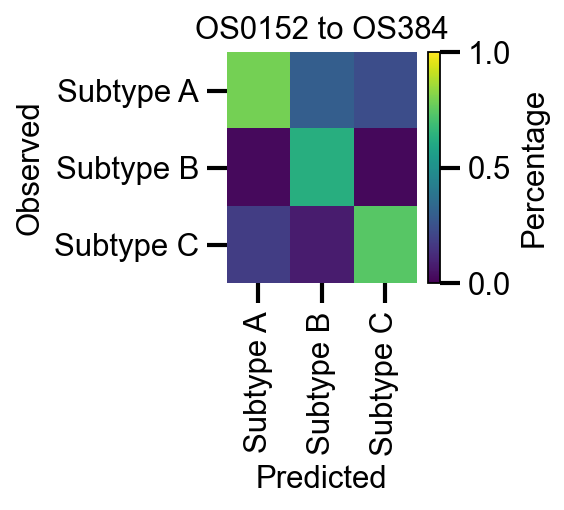

In [6]:

# Building the df for the heatmap
norm_df = df / df.sum(axis=0)

# Normalize the color map
norm = mpl.colors.Normalize(vmin=0, vmax=1)

# Setting the fig size
fig, ax = plt.subplots(figsize=(1.9, 1.9))

# Plot using imshow to avoid gridlines
cax = ax.imshow(norm_df, cmap='viridis', norm=norm, interpolation='none', aspect='auto')

# Setting ticks and labels
ax.set_xticks(np.arange(len(df.columns)))
ax.set_xticklabels(df.columns, rotation=90)
ax.set_yticks(np.arange(len(df.index)))
ax.set_yticklabels(df.index)

# Adding colorbar
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax, orientation='vertical')
cbar.set_label('Percentage')

# Labels and title
ax.set_xlabel("Predicted")
ax.set_ylabel("Observed")
ax.set_title("OS0152 to OS384")

# Remove the gridlines and spines
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Save the plot as an SVG file
plt.savefig('/Users/brendamelano/Desktop/OS152_OS384_scANVI.svg', format='svg', bbox_inches='tight', pad_inches=0)

# Show plot
plt.show()

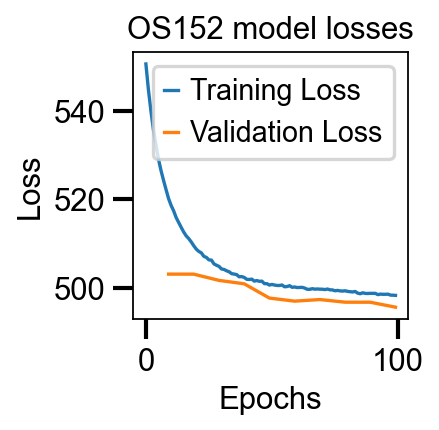

In [9]:
# F1 scores for OS152 transfer to OS384
#evaluate_and_plot_f1_scores(adata_152, "OS742", "OS152", output_file='/Users/brendamelano/Desktop/f1_scores_152_from_742.svg', font_size=10)

# Saving the training history as a separate object
training_history = vae_q.history

# Setting the fig size dimensions
plt.figure(figsize=(2.2, 2.2))


# Your existing plotting code
plt.plot(training_history['elbo_train'], label='Training Loss')
if 'elbo_validation' in training_history:
    plt.plot(training_history['elbo_validation'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('OS152 model losses')
plt.legend()

# Remove grid lines
plt.grid(False)

# Save the plot as an SVG file
plt.savefig('/Users/brendamelano/Desktop/training_history_plot.svg', format='svg')

# Show the plot
plt.show()


# Running simulation to test accuracy

In [24]:
adata_OS384 = adata_384

Accuracy: 0.684957
Precision: 0.718004
Recall: 0.684957
F1 Score: 0.668228
Confusion Matrix:
[[ 633  579  122]
 [  21 1208   11]
 [ 145  144  381]]
F1 Scores by Subtype:
Subtype A: 0.593530
Subtype B: 0.761905
Subtype C: 0.643581


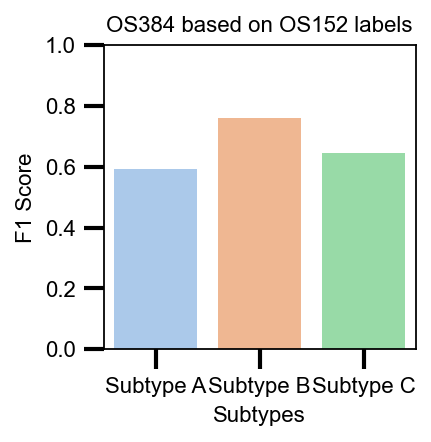

In [4]:
def evaluate_and_plot_f1_scores(adata, true_labels_name, predicted_labels_name, true_label_key='Subtype', prediction_key='predictions', output_file='f1_scores.svg', font_size=10):
    """
    Evaluate and plot F1 scores for different subtypes in the given AnnData object.

    Parameters:
    adata (AnnData): AnnData object containing true labels and predictions.
    true_labels_name (str): The name of the dataset from which true labels are derived.
    predicted_labels_name (str): The name of the dataset from which predicted labels are derived.
    true_label_key (str): Key for the true labels in `adata.obs`.
    prediction_key (str): Key for the predicted labels in `adata.obs`.
    output_file (str): The file path to save the SVG plot.
    font_size (int): Font size for the plot.

    Returns:
    None
    """
    # Extract true and predicted labels
    true_labels = adata.obs[true_label_key]
    predicted_labels = adata.obs[prediction_key]

    # Calculate overall metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    # Confusion Matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Classification report for detailed metrics per class
    class_report = classification_report(true_labels, predicted_labels, output_dict=True)

    # Extract F1 scores for each subtype
    f1_scores = {subtype: metrics['f1-score'] for subtype, metrics in class_report.items() if subtype not in ['accuracy', 'macro avg', 'weighted avg']}
    
    # Print overall metrics
    print(f"Accuracy: {accuracy:.6f}")
    print(f"Precision: {precision:.6f}")
    print(f"Recall: {recall:.6f}")
    print(f"F1 Score: {f1:.6f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    # Print F1 scores for each subtype
    print("F1 Scores by Subtype:")
    for subtype, score in f1_scores.items():
        print(f"{subtype}: {score:.6f}")
        
    # Set the font family and size globally for the plot
    plt.rcParams['font.size'] = font_size
    plt.rcParams['axes.titlesize'] = font_size
    plt.rcParams['axes.labelsize'] = font_size
    plt.rcParams['xtick.labelsize'] = font_size
    plt.rcParams['ytick.labelsize'] = font_size
    plt.rcParams['legend.fontsize'] = font_size
    plt.rcParams['figure.titlesize'] = font_size

    # Create bar plot for F1 scores
    subtypes = list(f1_scores.keys())
    scores = list(f1_scores.values())

    # Generate plot title using the provided names
    plot_title = f"{predicted_labels_name} based on {true_labels_name} labels"

    plt.figure(figsize=(2.5, 2.5))
    sns.barplot(x=subtypes, y=scores, palette='pastel')
    plt.ylim(0, 1)
    plt.xlabel('Subtypes')
    plt.ylabel('F1 Score')
    plt.title(plot_title)

    # Remove gridlines
    plt.grid(False)

    # Save the plot as SVG
    plt.savefig(output_file, format='svg')

    # Show the plot
    plt.show()

# F1 scores for OS152 transfer to OS384
evaluate_and_plot_f1_scores(adata_384, "OS152", "OS384", output_file='/Users/brendamelano/Desktop/f1_scores_384.svg', font_size=10)


In [15]:
import numpy as np
from sklearn.metrics import f1_score
import random

# Function to compute F1 score
def compute_f1_score(true_labels, predicted_labels):
    return f1_score(true_labels, predicted_labels, average='weighted')

# True and predicted labels from your model
true_labels = adata_384.obs["Subtype"]
predicted_labels = adata_384.obs["predictions"]

# Observed F1 score
observed_f1 = compute_f1_score(true_labels, predicted_labels)

# Number of permutations
n_permutations = 100000  # Increase the number of permutations
permuted_f1_scores = []

for _ in range(n_permutations):
    # Shuffle the true labels
    shuffled_labels = random.sample(list(true_labels), len(true_labels))
    
    # Compute the F1 score with shuffled labels
    permuted_f1 = compute_f1_score(shuffled_labels, predicted_labels)
    permuted_f1_scores.append(permuted_f1)

# Calculate p-value
p_value = np.mean([f1 >= observed_f1 for f1 in permuted_f1_scores])

# Set a minimum threshold for the p-value based on the number of permutations
min_p_value = 1 / n_permutations
p_value = max(p_value, min_p_value)

print(f'Observed F1 Score: {observed_f1:.6f}')
print(f'p-value: {p_value:.3e}')


Observed F1 Score: 0.668228
p-value: 1.000e-05


# OS384 to OS152

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/400:   0%|                                      | 0/400 [00:00<?, ?it/s]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 2/400:   0%|           | 1/400 [00:00<05:14,  1.27it/s, loss=547, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more info

Epoch 3/400:   0%|           | 2/400 [00:01<03:27,  1.92it/s, loss=492, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 4/400:   1%|           | 3/400 [00:01<02:51,  2.32it/s, loss=479, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 5/400:   1%|           | 4/400 [00:01<02:33,  2.58it/s, loss=474, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 6/400:   1%|▏          | 5/400 [00:02<02:23,  2.75it/s, loss=472, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 7/400:   2%|▏          | 6/400 [00:02<02:17,  2.86it/s, loss=469, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 8/400:   2%|▏          | 7/400 [00:02<02:13,  2.94it/s, loss=468, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 9/400:   2%|▏          | 8/400 [00:03<02:11,  2.99it/s, loss=465, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 10/400:   2%|▏         | 9/400 [00:03<02:09,  3.02it/s, loss=464, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 11/400:   2%|▏        | 10/400 [00:03<02:07,  3.06it/s, loss=463, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 12/400:   3%|▏        | 11/400 [00:04<02:05,  3.10it/s, loss=462, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 13/400:   3%|▎        | 12/400 [00:04<02:05,  3.09it/s, loss=460, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 14/400:   3%|▎        | 13/400 [00:04<02:04,  3.12it/s, loss=459, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 15/400:   4%|▎        | 14/400 [00:04<02:04,  3.11it/s, loss=458, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 16/400:   4%|▎        | 15/400 [00:05<02:03,  3.12it/s, loss=457, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 17/400:   4%|▎        | 16/400 [00:05<02:02,  3.14it/s, loss=455, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 18/400:   4%|▍        | 17/400 [00:05<02:01,  3.14it/s, loss=454, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 19/400:   4%|▍        | 18/400 [00:06<02:01,  3.14it/s, loss=453, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 20/400:   5%|▍        | 19/400 [00:06<02:00,  3.15it/s, loss=452, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 21/400:   5%|▍        | 20/400 [00:06<02:00,  3.15it/s, loss=451, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 22/400:   5%|▍        | 21/400 [00:07<02:00,  3.15it/s, loss=450, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 23/400:   6%|▍        | 22/400 [00:07<01:59,  3.15it/s, loss=449, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 24/400:   6%|▌        | 23/400 [00:07<01:59,  3.16it/s, loss=448, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 25/400:   6%|▌        | 24/400 [00:08<01:58,  3.16it/s, loss=448, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 26/400:   6%|▌        | 25/400 [00:08<01:58,  3.16it/s, loss=446, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 27/400:   6%|▌        | 26/400 [00:08<01:58,  3.17it/s, loss=445, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 28/400:   7%|▌        | 27/400 [00:09<01:58,  3.15it/s, loss=444, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 29/400:   7%|▋        | 28/400 [00:09<01:59,  3.11it/s, loss=444, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 30/400:   7%|▋        | 29/400 [00:09<02:00,  3.09it/s, loss=442, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 31/400:   8%|▋        | 30/400 [00:10<02:01,  3.04it/s, loss=442, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 32/400:   8%|▋        | 31/400 [00:10<02:02,  3.01it/s, loss=441, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 33/400:   8%|▋        | 32/400 [00:10<02:01,  3.03it/s, loss=440, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 34/400:   8%|▋        | 33/400 [00:11<01:59,  3.06it/s, loss=439, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 35/400:   8%|▊        | 34/400 [00:11<01:58,  3.09it/s, loss=439, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 36/400:   9%|▊        | 35/400 [00:11<01:57,  3.10it/s, loss=438, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 37/400:   9%|▊        | 36/400 [00:12<01:56,  3.13it/s, loss=437, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 38/400:   9%|▊        | 37/400 [00:12<01:56,  3.11it/s, loss=436, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 39/400:  10%|▊        | 38/400 [00:12<01:55,  3.13it/s, loss=436, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 40/400:  10%|▉        | 39/400 [00:12<01:54,  3.16it/s, loss=435, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 41/400:  10%|▉        | 40/400 [00:13<01:54,  3.16it/s, loss=434, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 42/400:  10%|▉        | 41/400 [00:13<01:53,  3.16it/s, loss=434, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 43/400:  10%|▉        | 42/400 [00:13<01:53,  3.15it/s, loss=433, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 44/400:  11%|▉        | 43/400 [00:14<01:53,  3.15it/s, loss=432, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 45/400:  11%|▉        | 44/400 [00:14<01:52,  3.17it/s, loss=432, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 46/400:  11%|█        | 45/400 [00:14<01:52,  3.15it/s, loss=431, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 47/400:  12%|█        | 46/400 [00:15<02:18,  2.55it/s, loss=430, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 48/400:  12%|█        | 47/400 [00:15<02:09,  2.72it/s, loss=430, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 49/400:  12%|█        | 48/400 [00:16<02:03,  2.84it/s, loss=429, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 50/400:  12%|█        | 49/400 [00:16<01:59,  2.94it/s, loss=428, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 51/400:  12%|█▏       | 50/400 [00:16<01:56,  3.01it/s, loss=428, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 52/400:  13%|█▏       | 51/400 [00:17<01:53,  3.07it/s, loss=427, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 53/400:  13%|█▏       | 52/400 [00:17<01:51,  3.11it/s, loss=426, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 54/400:  13%|█▏       | 53/400 [00:17<01:50,  3.14it/s, loss=426, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 55/400:  14%|█▏       | 54/400 [00:17<01:49,  3.15it/s, loss=425, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 56/400:  14%|█▏       | 55/400 [00:18<01:49,  3.16it/s, loss=425, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 57/400:  14%|█▎       | 56/400 [00:18<01:48,  3.16it/s, loss=425, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 58/400:  14%|█▎       | 57/400 [00:18<01:48,  3.16it/s, loss=424, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 59/400:  14%|█▎       | 58/400 [00:19<02:10,  2.63it/s, loss=423, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 60/400:  15%|█▎       | 59/400 [00:19<02:02,  2.78it/s, loss=423, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 61/400:  15%|█▎       | 60/400 [00:20<01:57,  2.90it/s, loss=422, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 62/400:  15%|█▎       | 61/400 [00:20<01:53,  2.99it/s, loss=422, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 63/400:  16%|█▍       | 62/400 [00:20<01:51,  3.04it/s, loss=421, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 64/400:  16%|█▍       | 63/400 [00:20<01:48,  3.09it/s, loss=421, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 65/400:  16%|█▍       | 64/400 [00:21<01:47,  3.12it/s, loss=420, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 66/400:  16%|█▍       | 65/400 [00:21<01:46,  3.14it/s, loss=421, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 67/400:  16%|█▍       | 66/400 [00:21<01:45,  3.17it/s, loss=419, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 68/400:  17%|█▌       | 67/400 [00:22<01:44,  3.17it/s, loss=420, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 69/400:  17%|█▌       | 68/400 [00:22<01:44,  3.19it/s, loss=419, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 70/400:  17%|█▌       | 69/400 [00:22<01:43,  3.20it/s, loss=418, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 71/400:  18%|█▌       | 70/400 [00:23<01:43,  3.20it/s, loss=418, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 72/400:  18%|█▌       | 71/400 [00:23<01:42,  3.20it/s, loss=418, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 73/400:  18%|█▌       | 72/400 [00:23<01:41,  3.22it/s, loss=417, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 74/400:  18%|█▋       | 73/400 [00:24<01:41,  3.22it/s, loss=416, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 75/400:  18%|█▋       | 74/400 [00:24<01:41,  3.22it/s, loss=416, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 76/400:  19%|█▋       | 75/400 [00:24<01:41,  3.20it/s, loss=416, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 77/400:  19%|█▋       | 76/400 [00:25<01:44,  3.10it/s, loss=415, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 78/400:  19%|█▋       | 77/400 [00:25<01:42,  3.15it/s, loss=415, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 79/400:  20%|█▊       | 78/400 [00:25<01:41,  3.18it/s, loss=414, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 80/400:  20%|█▊       | 79/400 [00:25<01:41,  3.17it/s, loss=414, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 81/400:  20%|█▊       | 80/400 [00:26<01:40,  3.19it/s, loss=414, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 82/400:  20%|█▊       | 81/400 [00:26<01:39,  3.20it/s, loss=414, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 83/400:  20%|█▊       | 82/400 [00:26<01:39,  3.20it/s, loss=413, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 84/400:  21%|█▊       | 83/400 [00:27<01:38,  3.21it/s, loss=413, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 85/400:  21%|█▉       | 84/400 [00:27<01:38,  3.21it/s, loss=412, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 86/400:  21%|█▉       | 85/400 [00:27<01:38,  3.21it/s, loss=412, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 87/400:  22%|█▉       | 86/400 [00:28<01:38,  3.19it/s, loss=412, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 88/400:  22%|█▉       | 87/400 [00:28<01:37,  3.20it/s, loss=411, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 89/400:  22%|█▉       | 88/400 [00:28<01:37,  3.21it/s, loss=411, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 90/400:  22%|██       | 89/400 [00:29<01:36,  3.21it/s, loss=411, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 91/400:  22%|██       | 90/400 [00:29<01:36,  3.22it/s, loss=410, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 92/400:  23%|██       | 91/400 [00:29<01:36,  3.20it/s, loss=410, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 93/400:  23%|██       | 92/400 [00:30<01:35,  3.22it/s, loss=410, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 94/400:  23%|██       | 93/400 [00:30<01:35,  3.22it/s, loss=409, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 95/400:  24%|██       | 94/400 [00:30<01:35,  3.20it/s, loss=409, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 96/400:  24%|██▏      | 95/400 [00:30<01:35,  3.20it/s, loss=409, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 97/400:  24%|██▏      | 96/400 [00:31<01:34,  3.21it/s, loss=408, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 98/400:  24%|██▏      | 97/400 [00:31<01:34,  3.21it/s, loss=409, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 99/400:  24%|██▏      | 98/400 [00:31<01:33,  3.22it/s, loss=408, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 100/400:  25%|█▉      | 99/400 [00:32<01:33,  3.22it/s, loss=408, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 101/400:  25%|█▊     | 100/400 [00:32<01:32,  3.23it/s, loss=407, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 102/400:  25%|█▊     | 101/400 [00:32<01:32,  3.23it/s, loss=407, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 103/400:  26%|█▊     | 102/400 [00:33<01:32,  3.24it/s, loss=407, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 104/400:  26%|█▊     | 103/400 [00:33<01:31,  3.24it/s, loss=406, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 105/400:  26%|█▊     | 104/400 [00:33<01:31,  3.25it/s, loss=406, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 106/400:  26%|█▊     | 105/400 [00:34<01:31,  3.22it/s, loss=407, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 107/400:  26%|█▊     | 106/400 [00:34<01:31,  3.22it/s, loss=406, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 108/400:  27%|█▊     | 107/400 [00:34<01:31,  3.21it/s, loss=406, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 109/400:  27%|█▉     | 108/400 [00:35<01:31,  3.21it/s, loss=405, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 110/400:  27%|█▉     | 109/400 [00:35<01:30,  3.20it/s, loss=406, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 111/400:  28%|█▉     | 110/400 [00:35<01:30,  3.20it/s, loss=405, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 112/400:  28%|█▉     | 111/400 [00:35<01:30,  3.20it/s, loss=405, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 113/400:  28%|█▉     | 112/400 [00:36<01:29,  3.22it/s, loss=405, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 114/400:  28%|█▉     | 113/400 [00:36<01:29,  3.22it/s, loss=404, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 115/400:  28%|█▉     | 114/400 [00:36<01:31,  3.11it/s, loss=405, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 116/400:  29%|██     | 115/400 [00:37<01:31,  3.11it/s, loss=404, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 117/400:  29%|██     | 116/400 [00:37<01:30,  3.13it/s, loss=404, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 118/400:  29%|██     | 117/400 [00:37<01:29,  3.16it/s, loss=404, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 119/400:  30%|██     | 118/400 [00:38<01:28,  3.18it/s, loss=403, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 120/400:  30%|██     | 119/400 [00:38<01:28,  3.19it/s, loss=404, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 121/400:  30%|██     | 120/400 [00:38<01:27,  3.19it/s, loss=403, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 122/400:  30%|██     | 121/400 [00:39<01:27,  3.20it/s, loss=402, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 123/400:  30%|██▏    | 122/400 [00:39<01:26,  3.21it/s, loss=402, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 124/400:  31%|██▏    | 123/400 [00:39<01:26,  3.21it/s, loss=403, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 125/400:  31%|██▏    | 124/400 [00:40<01:25,  3.22it/s, loss=402, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 126/400:  31%|██▏    | 125/400 [00:40<01:25,  3.23it/s, loss=402, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 127/400:  32%|██▏    | 126/400 [00:40<01:25,  3.22it/s, loss=402, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 128/400:  32%|██▏    | 127/400 [00:40<01:25,  3.20it/s, loss=402, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 129/400:  32%|██▏    | 128/400 [00:41<01:24,  3.23it/s, loss=402, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 130/400:  32%|██▎    | 129/400 [00:41<01:23,  3.23it/s, loss=401, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 131/400:  32%|██▎    | 130/400 [00:41<01:23,  3.23it/s, loss=401, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 132/400:  33%|██▎    | 131/400 [00:42<01:23,  3.23it/s, loss=401, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 133/400:  33%|██▎    | 132/400 [00:42<01:22,  3.24it/s, loss=401, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 134/400:  33%|██▎    | 133/400 [00:42<01:22,  3.23it/s, loss=401, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 135/400:  34%|██▎    | 134/400 [00:43<01:22,  3.23it/s, loss=401, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 136/400:  34%|██▎    | 135/400 [00:43<01:21,  3.23it/s, loss=400, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 137/400:  34%|██▍    | 136/400 [00:43<01:21,  3.23it/s, loss=400, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 138/400:  34%|██▍    | 137/400 [00:44<01:21,  3.23it/s, loss=400, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 139/400:  34%|██▍    | 138/400 [00:44<01:20,  3.25it/s, loss=400, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 140/400:  35%|██▍    | 139/400 [00:44<01:20,  3.24it/s, loss=400, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 141/400:  35%|██▍    | 140/400 [00:44<01:20,  3.22it/s, loss=400, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 142/400:  35%|██▍    | 141/400 [00:45<01:20,  3.22it/s, loss=400, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 143/400:  36%|██▍    | 142/400 [00:45<01:20,  3.22it/s, loss=400, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 144/400:  36%|██▌    | 143/400 [00:45<01:19,  3.22it/s, loss=399, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 145/400:  36%|██▌    | 144/400 [00:46<01:19,  3.23it/s, loss=399, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 146/400:  36%|██▌    | 145/400 [00:46<01:18,  3.23it/s, loss=399, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 147/400:  36%|██▌    | 146/400 [00:46<01:18,  3.25it/s, loss=399, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 148/400:  37%|██▌    | 147/400 [00:47<01:17,  3.25it/s, loss=399, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 149/400:  37%|██▌    | 148/400 [00:47<01:17,  3.25it/s, loss=399, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 150/400:  37%|██▌    | 149/400 [00:47<01:17,  3.25it/s, loss=399, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 151/400:  38%|██▋    | 150/400 [00:48<01:17,  3.24it/s, loss=398, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 152/400:  38%|██▋    | 151/400 [00:48<01:17,  3.23it/s, loss=398, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 153/400:  38%|██▋    | 152/400 [00:48<01:16,  3.24it/s, loss=398, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 154/400:  38%|██▋    | 153/400 [00:49<01:16,  3.24it/s, loss=398, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 155/400:  38%|██▋    | 154/400 [00:49<01:15,  3.25it/s, loss=398, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 156/400:  39%|██▋    | 155/400 [00:49<01:15,  3.26it/s, loss=398, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 157/400:  39%|██▋    | 156/400 [00:49<01:15,  3.25it/s, loss=398, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 158/400:  39%|██▋    | 157/400 [00:50<01:14,  3.27it/s, loss=398, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 159/400:  40%|██▊    | 158/400 [00:50<01:13,  3.28it/s, loss=398, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 160/400:  40%|██▊    | 159/400 [00:50<01:25,  2.83it/s, loss=397, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 161/400:  40%|██▊    | 160/400 [00:51<01:21,  2.94it/s, loss=397, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 162/400:  40%|██▊    | 161/400 [00:51<01:18,  3.03it/s, loss=397, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 163/400:  40%|██▊    | 162/400 [00:51<01:16,  3.10it/s, loss=397, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 164/400:  41%|██▊    | 163/400 [00:52<01:15,  3.16it/s, loss=397, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 165/400:  41%|██▊    | 164/400 [00:52<01:14,  3.19it/s, loss=397, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 166/400:  41%|██▉    | 165/400 [00:52<01:13,  3.21it/s, loss=397, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 167/400:  42%|██▉    | 166/400 [00:53<01:12,  3.21it/s, loss=397, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 168/400:  42%|██▉    | 167/400 [00:53<01:12,  3.21it/s, loss=396, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 169/400:  42%|██▉    | 168/400 [00:53<01:11,  3.23it/s, loss=397, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 170/400:  42%|██▉    | 169/400 [00:54<01:11,  3.23it/s, loss=396, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 171/400:  42%|██▉    | 170/400 [00:54<01:11,  3.23it/s, loss=397, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 172/400:  43%|██▉    | 171/400 [00:54<01:10,  3.24it/s, loss=396, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 173/400:  43%|███    | 172/400 [00:54<01:10,  3.25it/s, loss=396, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 174/400:  43%|███    | 173/400 [00:55<01:09,  3.24it/s, loss=396, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 175/400:  44%|███    | 174/400 [00:55<01:09,  3.24it/s, loss=396, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 176/400:  44%|███    | 175/400 [00:55<01:09,  3.23it/s, loss=396, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 177/400:  44%|███    | 176/400 [00:56<01:09,  3.20it/s, loss=396, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 178/400:  44%|███    | 177/400 [00:56<01:09,  3.21it/s, loss=396, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 179/400:  44%|███    | 178/400 [00:56<01:08,  3.24it/s, loss=396, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 180/400:  45%|███▏   | 179/400 [00:57<01:08,  3.25it/s, loss=396, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 181/400:  45%|███▏   | 180/400 [00:57<01:07,  3.25it/s, loss=396, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 182/400:  45%|███▏   | 181/400 [00:57<01:07,  3.26it/s, loss=395, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 183/400:  46%|███▏   | 182/400 [00:58<01:06,  3.27it/s, loss=396, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 184/400:  46%|███▏   | 183/400 [00:58<01:06,  3.26it/s, loss=396, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 185/400:  46%|███▏   | 184/400 [00:58<01:06,  3.26it/s, loss=395, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 186/400:  46%|███▏   | 185/400 [00:58<01:05,  3.26it/s, loss=396, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 187/400:  46%|███▎   | 186/400 [00:59<01:05,  3.26it/s, loss=395, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 188/400:  47%|███▎   | 187/400 [00:59<01:05,  3.24it/s, loss=396, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 189/400:  47%|███▎   | 188/400 [00:59<01:06,  3.20it/s, loss=395, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 190/400:  47%|███▎   | 189/400 [01:00<01:05,  3.23it/s, loss=395, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 191/400:  48%|███▎   | 190/400 [01:00<01:04,  3.24it/s, loss=395, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 192/400:  48%|███▎   | 191/400 [01:00<01:04,  3.24it/s, loss=395, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 193/400:  48%|███▎   | 192/400 [01:01<01:04,  3.25it/s, loss=395, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 194/400:  48%|███▍   | 193/400 [01:01<01:03,  3.25it/s, loss=394, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 195/400:  48%|███▍   | 194/400 [01:01<01:03,  3.23it/s, loss=395, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 196/400:  49%|███▍   | 195/400 [01:02<01:03,  3.24it/s, loss=395, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 197/400:  49%|███▍   | 196/400 [01:02<01:02,  3.26it/s, loss=394, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 198/400:  49%|███▍   | 197/400 [01:02<01:02,  3.25it/s, loss=395, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 199/400:  50%|███▍   | 198/400 [01:03<01:02,  3.26it/s, loss=395, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 200/400:  50%|███▍   | 199/400 [01:03<01:01,  3.27it/s, loss=394, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 201/400:  50%|███▌   | 200/400 [01:03<01:01,  3.26it/s, loss=394, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 202/400:  50%|███▌   | 201/400 [01:03<01:00,  3.28it/s, loss=395, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 203/400:  50%|███▌   | 202/400 [01:04<01:00,  3.28it/s, loss=394, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 204/400:  51%|███▌   | 203/400 [01:04<01:00,  3.27it/s, loss=394, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 205/400:  51%|███▌   | 204/400 [01:04<00:59,  3.28it/s, loss=394, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 206/400:  51%|███▌   | 205/400 [01:05<00:59,  3.27it/s, loss=394, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 207/400:  52%|███▌   | 206/400 [01:05<00:59,  3.27it/s, loss=394, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 208/400:  52%|███▌   | 207/400 [01:05<00:59,  3.27it/s, loss=394, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 209/400:  52%|███▋   | 208/400 [01:06<00:58,  3.28it/s, loss=394, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 210/400:  52%|███▋   | 209/400 [01:06<00:58,  3.26it/s, loss=394, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 211/400:  52%|███▋   | 210/400 [01:06<00:58,  3.27it/s, loss=394, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 212/400:  53%|███▋   | 211/400 [01:06<00:57,  3.28it/s, loss=394, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 213/400:  53%|███▋   | 212/400 [01:07<00:57,  3.28it/s, loss=394, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 214/400:  53%|███▋   | 213/400 [01:07<00:57,  3.27it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 215/400:  54%|███▋   | 214/400 [01:07<00:57,  3.26it/s, loss=394, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 216/400:  54%|███▊   | 215/400 [01:08<00:57,  3.25it/s, loss=394, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 217/400:  54%|███▊   | 216/400 [01:08<00:56,  3.27it/s, loss=394, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 218/400:  54%|███▊   | 217/400 [01:08<00:56,  3.25it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 219/400:  55%|███▊   | 218/400 [01:09<00:59,  3.08it/s, loss=394, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 220/400:  55%|███▊   | 219/400 [01:09<01:01,  2.92it/s, loss=394, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 221/400:  55%|███▊   | 220/400 [01:09<01:02,  2.90it/s, loss=394, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 222/400:  55%|███▊   | 221/400 [01:10<00:59,  2.98it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 223/400:  56%|███▉   | 222/400 [01:10<00:59,  3.00it/s, loss=394, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 224/400:  56%|███▉   | 223/400 [01:10<00:58,  3.04it/s, loss=394, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 225/400:  56%|███▉   | 224/400 [01:11<00:56,  3.09it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 226/400:  56%|███▉   | 225/400 [01:11<00:55,  3.14it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 227/400:  56%|███▉   | 226/400 [01:11<00:54,  3.18it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 228/400:  57%|███▉   | 227/400 [01:12<00:54,  3.18it/s, loss=394, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 229/400:  57%|███▉   | 228/400 [01:12<00:53,  3.22it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 230/400:  57%|████   | 229/400 [01:12<00:52,  3.25it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 231/400:  57%|████   | 230/400 [01:13<00:52,  3.27it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 232/400:  58%|████   | 231/400 [01:13<00:51,  3.29it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 233/400:  58%|████   | 232/400 [01:13<00:51,  3.29it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 234/400:  58%|████   | 233/400 [01:13<00:50,  3.29it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 235/400:  58%|████   | 234/400 [01:14<00:50,  3.28it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 236/400:  59%|████   | 235/400 [01:14<00:50,  3.29it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 237/400:  59%|████▏  | 236/400 [01:14<00:49,  3.29it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 238/400:  59%|████▏  | 237/400 [01:15<00:49,  3.29it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 239/400:  60%|████▏  | 238/400 [01:15<00:49,  3.29it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 240/400:  60%|████▏  | 239/400 [01:15<00:48,  3.29it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 241/400:  60%|████▏  | 240/400 [01:16<00:48,  3.27it/s, loss=394, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 242/400:  60%|████▏  | 241/400 [01:16<00:48,  3.28it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 243/400:  60%|████▏  | 242/400 [01:16<00:48,  3.29it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 244/400:  61%|████▎  | 243/400 [01:16<00:47,  3.31it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 245/400:  61%|████▎  | 244/400 [01:17<00:47,  3.30it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 246/400:  61%|████▎  | 245/400 [01:17<00:46,  3.31it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 247/400:  62%|████▎  | 246/400 [01:17<00:46,  3.31it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 248/400:  62%|████▎  | 247/400 [01:18<00:46,  3.31it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 249/400:  62%|████▎  | 248/400 [01:18<00:46,  3.30it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 250/400:  62%|████▎  | 249/400 [01:18<00:45,  3.31it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 251/400:  62%|████▍  | 250/400 [01:19<00:45,  3.31it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 252/400:  63%|████▍  | 251/400 [01:19<00:44,  3.31it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 253/400:  63%|████▍  | 252/400 [01:19<00:44,  3.30it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 254/400:  63%|████▍  | 253/400 [01:19<00:44,  3.30it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 255/400:  64%|████▍  | 254/400 [01:20<00:44,  3.30it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 256/400:  64%|████▍  | 255/400 [01:20<00:44,  3.29it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 257/400:  64%|████▍  | 256/400 [01:20<00:43,  3.31it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 258/400:  64%|████▍  | 257/400 [01:21<00:43,  3.30it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 259/400:  64%|████▌  | 258/400 [01:21<00:43,  3.30it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 260/400:  65%|████▌  | 259/400 [01:21<00:42,  3.30it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 261/400:  65%|████▌  | 260/400 [01:22<00:42,  3.30it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 262/400:  65%|████▌  | 261/400 [01:22<00:42,  3.30it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 263/400:  66%|████▌  | 262/400 [01:22<00:41,  3.30it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 264/400:  66%|████▌  | 263/400 [01:23<00:41,  3.31it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 265/400:  66%|████▌  | 264/400 [01:23<00:41,  3.30it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 266/400:  66%|████▋  | 265/400 [01:23<00:40,  3.31it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 267/400:  66%|████▋  | 266/400 [01:23<00:40,  3.30it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 268/400:  67%|████▋  | 267/400 [01:24<00:40,  3.32it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 269/400:  67%|████▋  | 268/400 [01:24<00:39,  3.31it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 270/400:  67%|████▋  | 269/400 [01:24<00:39,  3.31it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 271/400:  68%|████▋  | 270/400 [01:25<00:39,  3.31it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 272/400:  68%|████▋  | 271/400 [01:25<00:39,  3.31it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 273/400:  68%|████▊  | 272/400 [01:25<00:38,  3.32it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 274/400:  68%|████▊  | 273/400 [01:26<00:38,  3.31it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 275/400:  68%|████▊  | 274/400 [01:26<00:38,  3.31it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 276/400:  69%|████▊  | 275/400 [01:26<00:37,  3.33it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 277/400:  69%|████▊  | 276/400 [01:26<00:37,  3.32it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 278/400:  69%|████▊  | 277/400 [01:27<00:37,  3.32it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 279/400:  70%|████▊  | 278/400 [01:27<00:36,  3.32it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 280/400:  70%|████▉  | 279/400 [01:27<00:36,  3.32it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 281/400:  70%|████▉  | 280/400 [01:28<00:36,  3.30it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 282/400:  70%|████▉  | 281/400 [01:28<00:36,  3.30it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 283/400:  70%|████▉  | 282/400 [01:28<00:35,  3.32it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 284/400:  71%|████▉  | 283/400 [01:29<00:35,  3.27it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 285/400:  71%|████▉  | 284/400 [01:29<00:35,  3.28it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 286/400:  71%|████▉  | 285/400 [01:29<00:34,  3.30it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 287/400:  72%|█████  | 286/400 [01:29<00:34,  3.28it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 288/400:  72%|█████  | 287/400 [01:30<00:34,  3.29it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 289/400:  72%|█████  | 288/400 [01:30<00:33,  3.30it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 290/400:  72%|█████  | 289/400 [01:30<00:33,  3.31it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 291/400:  72%|█████  | 290/400 [01:31<00:33,  3.30it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 292/400:  73%|█████  | 291/400 [01:31<00:32,  3.31it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 293/400:  73%|█████  | 292/400 [01:31<00:32,  3.31it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 294/400:  73%|█████▏ | 293/400 [01:32<00:32,  3.31it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 295/400:  74%|█████▏ | 294/400 [01:32<00:32,  3.31it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 296/400:  74%|█████▏ | 295/400 [01:32<00:31,  3.32it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 297/400:  74%|█████▏ | 296/400 [01:32<00:31,  3.33it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 298/400:  74%|█████▏ | 297/400 [01:33<00:31,  3.31it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 299/400:  74%|█████▏ | 298/400 [01:33<00:30,  3.33it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 300/400:  75%|█████▏ | 299/400 [01:33<00:30,  3.31it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 301/400:  75%|█████▎ | 300/400 [01:34<00:30,  3.30it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 302/400:  75%|█████▎ | 301/400 [01:34<00:29,  3.31it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 303/400:  76%|█████▎ | 302/400 [01:34<00:29,  3.31it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 304/400:  76%|█████▎ | 303/400 [01:35<00:29,  3.31it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 305/400:  76%|█████▎ | 304/400 [01:35<00:28,  3.31it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 306/400:  76%|█████▎ | 305/400 [01:35<00:28,  3.32it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 307/400:  76%|█████▎ | 306/400 [01:36<00:28,  3.30it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 308/400:  77%|█████▎ | 307/400 [01:36<00:28,  3.30it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 309/400:  77%|█████▍ | 308/400 [01:36<00:27,  3.31it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 310/400:  77%|█████▍ | 309/400 [01:36<00:29,  3.09it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 311/400:  78%|█████▍ | 310/400 [01:37<00:28,  3.11it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 312/400:  78%|█████▍ | 311/400 [01:37<00:28,  3.18it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 313/400:  78%|█████▍ | 312/400 [01:37<00:27,  3.21it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 314/400:  78%|█████▍ | 313/400 [01:38<00:26,  3.24it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 315/400:  78%|█████▍ | 314/400 [01:38<00:26,  3.26it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 316/400:  79%|█████▌ | 315/400 [01:38<00:25,  3.28it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 317/400:  79%|█████▌ | 316/400 [01:39<00:25,  3.29it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 318/400:  79%|█████▌ | 317/400 [01:39<00:25,  3.29it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 319/400:  80%|█████▌ | 318/400 [01:39<00:25,  3.28it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 320/400:  80%|█████▌ | 319/400 [01:40<00:24,  3.27it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 321/400:  80%|█████▌ | 320/400 [01:40<00:24,  3.29it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 322/400:  80%|█████▌ | 321/400 [01:40<00:23,  3.31it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 323/400:  80%|█████▋ | 322/400 [01:40<00:23,  3.31it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 324/400:  81%|█████▋ | 323/400 [01:41<00:23,  3.31it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 325/400:  81%|█████▋ | 324/400 [01:41<00:22,  3.32it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 326/400:  81%|█████▋ | 325/400 [01:41<00:22,  3.33it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 327/400:  82%|█████▋ | 326/400 [01:42<00:22,  3.33it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 328/400:  82%|█████▋ | 327/400 [01:42<00:21,  3.32it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 329/400:  82%|█████▋ | 328/400 [01:42<00:21,  3.33it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 330/400:  82%|█████▊ | 329/400 [01:43<00:21,  3.32it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 331/400:  82%|█████▊ | 330/400 [01:43<00:21,  3.33it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 332/400:  83%|█████▊ | 331/400 [01:43<00:20,  3.33it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 333/400:  83%|█████▊ | 332/400 [01:43<00:20,  3.31it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 334/400:  83%|█████▊ | 333/400 [01:44<00:20,  3.32it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 335/400:  84%|█████▊ | 334/400 [01:44<00:19,  3.32it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 336/400:  84%|█████▊ | 335/400 [01:44<00:19,  3.32it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 337/400:  84%|█████▉ | 336/400 [01:45<00:19,  3.31it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 338/400:  84%|█████▉ | 337/400 [01:45<00:18,  3.32it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 339/400:  84%|█████▉ | 338/400 [01:45<00:18,  3.32it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 340/400:  85%|█████▉ | 339/400 [01:46<00:18,  3.30it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 341/400:  85%|█████▉ | 340/400 [01:46<00:18,  3.31it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 342/400:  85%|█████▉ | 341/400 [01:46<00:17,  3.32it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 343/400:  86%|█████▉ | 342/400 [01:46<00:17,  3.31it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 344/400:  86%|██████ | 343/400 [01:47<00:17,  3.32it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 345/400:  86%|██████ | 344/400 [01:47<00:16,  3.32it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 346/400:  86%|██████ | 345/400 [01:47<00:16,  3.31it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 347/400:  86%|██████ | 346/400 [01:48<00:16,  3.23it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 348/400:  87%|██████ | 347/400 [01:48<00:17,  3.11it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 349/400:  87%|██████ | 348/400 [01:48<00:16,  3.15it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 350/400:  87%|██████ | 349/400 [01:49<00:15,  3.20it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 351/400:  88%|██████▏| 350/400 [01:49<00:15,  3.25it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 352/400:  88%|██████▏| 351/400 [01:49<00:15,  3.24it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 353/400:  88%|██████▏| 352/400 [01:50<00:14,  3.26it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 354/400:  88%|██████▏| 353/400 [01:50<00:14,  3.28it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 355/400:  88%|██████▏| 354/400 [01:50<00:13,  3.29it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 356/400:  89%|██████▏| 355/400 [01:50<00:13,  3.30it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 357/400:  89%|██████▏| 356/400 [01:51<00:13,  3.32it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 358/400:  89%|██████▏| 357/400 [01:51<00:12,  3.33it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 359/400:  90%|██████▎| 358/400 [01:51<00:12,  3.33it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 360/400:  90%|██████▎| 359/400 [01:52<00:12,  3.31it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 361/400:  90%|██████▎| 360/400 [01:52<00:12,  3.32it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 362/400:  90%|██████▎| 361/400 [01:52<00:11,  3.31it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 363/400:  90%|██████▎| 362/400 [01:53<00:11,  3.32it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 364/400:  91%|██████▎| 363/400 [01:53<00:11,  3.33it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 365/400:  91%|██████▎| 364/400 [01:53<00:10,  3.29it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 366/400:  91%|██████▍| 365/400 [01:53<00:10,  3.30it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 367/400:  92%|██████▍| 366/400 [01:54<00:10,  3.31it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 368/400:  92%|██████▍| 367/400 [01:54<00:09,  3.30it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 369/400:  92%|██████▍| 368/400 [01:54<00:09,  3.32it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 370/400:  92%|██████▍| 369/400 [01:55<00:09,  3.32it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 371/400:  92%|██████▍| 370/400 [01:55<00:09,  3.32it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 372/400:  93%|██████▍| 371/400 [01:55<00:08,  3.32it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 373/400:  93%|██████▌| 372/400 [01:56<00:08,  3.29it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 374/400:  93%|██████▌| 373/400 [01:56<00:08,  3.27it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 375/400:  94%|██████▌| 374/400 [01:56<00:07,  3.29it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 376/400:  94%|██████▌| 375/400 [01:57<00:07,  3.29it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 377/400:  94%|██████▌| 376/400 [01:57<00:07,  3.30it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 378/400:  94%|██████▌| 377/400 [01:57<00:06,  3.29it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 379/400:  94%|██████▌| 378/400 [01:57<00:06,  3.29it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 380/400:  95%|██████▋| 379/400 [01:58<00:06,  3.29it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 381/400:  95%|██████▋| 380/400 [01:58<00:06,  3.31it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 382/400:  95%|██████▋| 381/400 [01:58<00:05,  3.31it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 383/400:  96%|██████▋| 382/400 [01:59<00:05,  3.32it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 384/400:  96%|██████▋| 383/400 [01:59<00:05,  3.32it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 385/400:  96%|██████▋| 384/400 [01:59<00:04,  3.32it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 386/400:  96%|██████▋| 385/400 [02:00<00:04,  3.32it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 387/400:  96%|██████▊| 386/400 [02:00<00:04,  3.33it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 388/400:  97%|██████▊| 387/400 [02:00<00:03,  3.34it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 389/400:  97%|██████▊| 388/400 [02:00<00:03,  3.33it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 390/400:  97%|██████▊| 389/400 [02:01<00:03,  3.32it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 391/400:  98%|██████▊| 390/400 [02:01<00:02,  3.34it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 392/400:  98%|██████▊| 391/400 [02:01<00:02,  3.34it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 393/400:  98%|██████▊| 392/400 [02:02<00:02,  3.34it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 394/400:  98%|██████▉| 393/400 [02:02<00:02,  3.32it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 395/400:  98%|██████▉| 394/400 [02:02<00:01,  3.32it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 396/400:  99%|██████▉| 395/400 [02:03<00:01,  3.32it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 397/400:  99%|██████▉| 396/400 [02:03<00:01,  3.32it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 398/400:  99%|██████▉| 397/400 [02:03<00:00,  3.32it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 399/400: 100%|██████▉| 398/400 [02:03<00:00,  3.32it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 400/400: 100%|██████▉| 399/400 [02:04<00:00,  3.33it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 400/400: 100%|███████| 400/400 [02:04<00:00,  3.32it/s, loss=393, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|███████| 400/400 [02:04<00:00,  3.21it/s, loss=393, v_num=1]
computing neighbors


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
running Leiden clustering
    finished: found 4 clusters and added
    'leiden_scVI', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


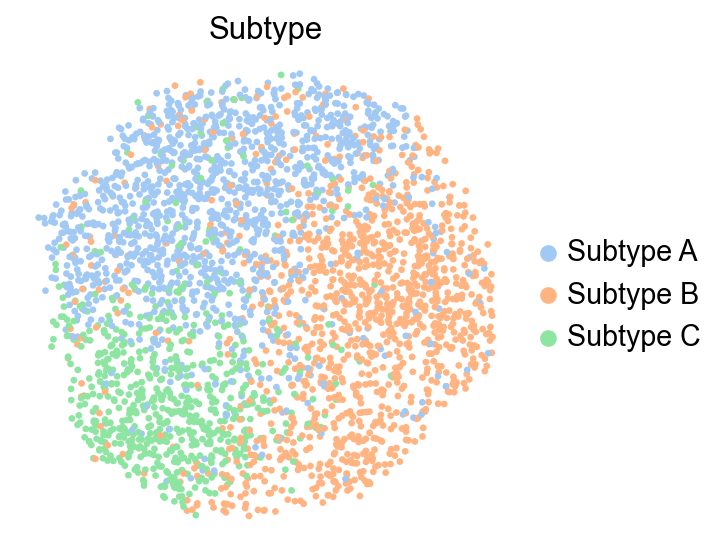

INFO     Training for 20 epochs.                                                                                   


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:91: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/20:   0%|                                        | 0/20 [00:00<?, ?it/s]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 2/20:   5%|▋            | 1/20 [00:00<00:11,  1.61it/s, loss=436, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 3/20:  10%|█▎           | 2/20 [00:01<00:10,  1.66it/s, loss=423, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 4/20:  15%|█▉           | 3/20 [00:01<00:10,  1.69it/s, loss=420, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 5/20:  20%|██▌          | 4/20 [00:02<00:09,  1.70it/s, loss=416, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 6/20:  25%|███▎         | 5/20 [00:02<00:08,  1.70it/s, loss=414, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 7/20:  30%|███▉         | 6/20 [00:03<00:08,  1.71it/s, loss=413, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 8/20:  35%|████▌        | 7/20 [00:04<00:07,  1.71it/s, loss=411, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 9/20:  40%|█████▏       | 8/20 [00:04<00:06,  1.72it/s, loss=409, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 10/20:  45%|█████▍      | 9/20 [00:05<00:06,  1.71it/s, loss=408, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 11/20:  50%|█████▌     | 10/20 [00:05<00:05,  1.70it/s, loss=407, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 12/20:  55%|██████     | 11/20 [00:06<00:05,  1.71it/s, loss=407, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 13/20:  60%|██████▌    | 12/20 [00:07<00:04,  1.71it/s, loss=406, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 14/20:  65%|███████▏   | 13/20 [00:07<00:04,  1.71it/s, loss=405, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 15/20:  70%|███████▋   | 14/20 [00:08<00:03,  1.70it/s, loss=405, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 16/20:  75%|████████▎  | 15/20 [00:08<00:02,  1.71it/s, loss=404, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 17/20:  80%|████████▊  | 16/20 [00:09<00:02,  1.71it/s, loss=404, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 18/20:  85%|█████████▎ | 17/20 [00:09<00:01,  1.71it/s, loss=404, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 19/20:  90%|█████████▉ | 18/20 [00:10<00:01,  1.71it/s, loss=403, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 20/20:  95%|██████████▍| 19/20 [00:11<00:00,  1.71it/s, loss=403, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 20/20: 100%|███████████| 20/20 [00:11<00:00,  1.72it/s, loss=403, v_num=1]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|███████████| 20/20 [00:11<00:00,  1.71it/s, loss=403, v_num=1]
computing neighbors


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


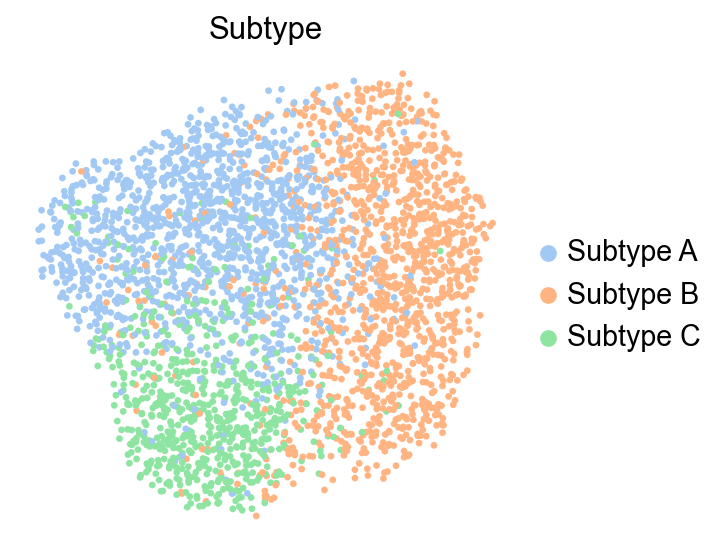

INFO     File OS384_model_scanvi_full_152/model.pt already downloaded                                              
INFO     Found 100.0% reference vars in query data.                                                                
INFO     File OS384_model_scanvi_full_152/model.pt already downloaded                                              
INFO     Training for 100 epochs.                                                                                  


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:91: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/100:   0%|                                      | 0/100 [00:00<?, ?it/s]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 2/100:   1%|           | 1/100 [00:00<01:35,  1.03it/s, loss=419, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 3/100:   2%|▏          | 2/100 [00:01<01:36,  1.02it/s, loss=415, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 4/100:   3%|▎          | 3/100 [00:02<01:34,  1.03it/s, loss=412, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 5/100:   4%|▍          | 4/100 [00:03<01:32,  1.03it/s, loss=409, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 6/100:   5%|▌          | 5/100 [00:04<01:31,  1.04it/s, loss=408, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 7/100:   6%|▋          | 6/100 [00:05<01:30,  1.04it/s, loss=404, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 8/100:   7%|▊          | 7/100 [00:06<01:29,  1.04it/s, loss=404, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 9/100:   8%|▉          | 8/100 [00:07<01:29,  1.02it/s, loss=404, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 10/100:   9%|▉         | 9/100 [00:08<01:29,  1.02it/s, loss=402, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 11/100:  10%|▉        | 10/100 [00:09<01:29,  1.00it/s, loss=400, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 12/100:  11%|▉        | 11/100 [00:10<01:28,  1.01it/s, loss=399, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 13/100:  12%|█        | 12/100 [00:11<01:27,  1.01it/s, loss=398, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 14/100:  13%|█▏       | 13/100 [00:12<01:27,  1.01s/it, loss=397, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 15/100:  14%|█▎       | 14/100 [00:14<01:43,  1.21s/it, loss=395, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 16/100:  15%|█▎       | 15/100 [00:15<01:36,  1.13s/it, loss=395, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 17/100:  16%|█▍       | 16/100 [00:16<01:30,  1.08s/it, loss=395, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 18/100:  17%|█▌       | 17/100 [00:17<01:26,  1.05s/it, loss=394, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 19/100:  18%|█▌       | 18/100 [00:18<01:23,  1.02s/it, loss=394, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 20/100:  19%|█▋       | 19/100 [00:19<01:21,  1.00s/it, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 21/100:  20%|█▊       | 20/100 [00:20<01:20,  1.01s/it, loss=394, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 22/100:  21%|█▉       | 21/100 [00:21<01:18,  1.00it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 23/100:  22%|█▉       | 22/100 [00:22<01:16,  1.02it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 24/100:  23%|██       | 23/100 [00:23<01:15,  1.02it/s, loss=390, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 25/100:  24%|██▏      | 24/100 [00:24<01:13,  1.03it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 26/100:  25%|██▎      | 25/100 [00:25<01:12,  1.03it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 27/100:  26%|██▎      | 26/100 [00:26<01:11,  1.04it/s, loss=391, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 28/100:  27%|██▍      | 27/100 [00:27<01:10,  1.04it/s, loss=391, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 29/100:  28%|██▌      | 28/100 [00:28<01:09,  1.03it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 30/100:  29%|██▌      | 29/100 [00:28<01:08,  1.04it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 31/100:  30%|██▋      | 30/100 [00:29<01:08,  1.02it/s, loss=391, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 32/100:  31%|██▊      | 31/100 [00:30<01:07,  1.02it/s, loss=391, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 33/100:  32%|██▉      | 32/100 [00:31<01:06,  1.03it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 34/100:  33%|██▉      | 33/100 [00:32<01:04,  1.03it/s, loss=391, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 35/100:  34%|███      | 34/100 [00:33<01:03,  1.04it/s, loss=391, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 36/100:  35%|███▏     | 35/100 [00:34<01:02,  1.04it/s, loss=391, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 37/100:  36%|███▏     | 36/100 [00:35<01:01,  1.04it/s, loss=391, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 38/100:  37%|███▎     | 37/100 [00:36<01:00,  1.04it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 39/100:  38%|███▍     | 38/100 [00:37<00:59,  1.04it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 40/100:  39%|███▌     | 39/100 [00:38<00:58,  1.04it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 41/100:  40%|███▌     | 40/100 [00:39<00:58,  1.02it/s, loss=391, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 42/100:  41%|███▋     | 41/100 [00:40<00:57,  1.02it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 43/100:  42%|███▊     | 42/100 [00:41<00:56,  1.02it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 44/100:  43%|███▊     | 43/100 [00:42<00:56,  1.02it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 45/100:  44%|███▉     | 44/100 [00:43<00:54,  1.02it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 46/100:  45%|████     | 45/100 [00:44<00:53,  1.03it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 47/100:  46%|████▏    | 46/100 [00:45<00:52,  1.03it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 48/100:  47%|████▏    | 47/100 [00:46<00:50,  1.04it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 49/100:  48%|████▎    | 48/100 [00:47<00:49,  1.04it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 50/100:  49%|████▍    | 49/100 [00:48<00:48,  1.05it/s, loss=394, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 51/100:  50%|████▌    | 50/100 [00:49<00:48,  1.02it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 52/100:  51%|████▌    | 51/100 [00:50<00:48,  1.02it/s, loss=392, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 53/100:  52%|████▋    | 52/100 [00:51<00:46,  1.03it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 54/100:  53%|████▊    | 53/100 [00:52<00:45,  1.03it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 55/100:  54%|████▊    | 54/100 [00:53<00:44,  1.04it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 56/100:  55%|████▉    | 55/100 [00:54<00:43,  1.04it/s, loss=393, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 57/100:  56%|█████    | 56/100 [00:55<00:42,  1.04it/s, loss=394, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 58/100:  57%|█████▏   | 57/100 [00:56<00:41,  1.04it/s, loss=394, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 59/100:  58%|█████▏   | 58/100 [00:57<00:40,  1.04it/s, loss=394, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 60/100:  59%|█████▎   | 59/100 [00:58<00:39,  1.04it/s, loss=394, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 61/100:  60%|█████▍   | 60/100 [00:59<00:39,  1.01it/s, loss=394, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 62/100:  61%|█████▍   | 61/100 [01:00<00:38,  1.02it/s, loss=394, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 63/100:  62%|█████▌   | 62/100 [01:00<00:37,  1.03it/s, loss=395, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 64/100:  63%|█████▋   | 63/100 [01:01<00:35,  1.03it/s, loss=395, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 65/100:  64%|█████▊   | 64/100 [01:02<00:34,  1.04it/s, loss=395, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 66/100:  65%|█████▊   | 65/100 [01:03<00:33,  1.04it/s, loss=396, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 67/100:  66%|█████▉   | 66/100 [01:04<00:32,  1.04it/s, loss=395, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 68/100:  67%|██████   | 67/100 [01:05<00:31,  1.04it/s, loss=395, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 69/100:  68%|██████   | 68/100 [01:06<00:31,  1.02it/s, loss=396, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 70/100:  69%|██████▏  | 69/100 [01:07<00:31,  1.02s/it, loss=395, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 71/100:  70%|██████▎  | 70/100 [01:08<00:31,  1.03s/it, loss=395, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 72/100:  71%|██████▍  | 71/100 [01:09<00:29,  1.01s/it, loss=396, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 73/100:  72%|██████▍  | 72/100 [01:10<00:27,  1.00it/s, loss=397, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 74/100:  73%|██████▌  | 73/100 [01:11<00:26,  1.01it/s, loss=395, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 75/100:  74%|██████▋  | 74/100 [01:12<00:25,  1.02it/s, loss=397, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 76/100:  75%|██████▊  | 75/100 [01:13<00:24,  1.03it/s, loss=396, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 77/100:  76%|██████▊  | 76/100 [01:14<00:23,  1.03it/s, loss=397, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 78/100:  77%|██████▉  | 77/100 [01:15<00:22,  1.03it/s, loss=397, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 79/100:  78%|███████  | 78/100 [01:16<00:21,  1.04it/s, loss=397, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 80/100:  79%|███████  | 79/100 [01:17<00:20,  1.04it/s, loss=398, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 81/100:  80%|███████▏ | 80/100 [01:18<00:19,  1.02it/s, loss=397, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 82/100:  81%|███████▎ | 81/100 [01:19<00:18,  1.02it/s, loss=398, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 83/100:  82%|███████▍ | 82/100 [01:20<00:17,  1.03it/s, loss=399, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 84/100:  83%|███████▍ | 83/100 [01:21<00:16,  1.04it/s, loss=398, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 85/100:  84%|███████▌ | 84/100 [01:22<00:15,  1.04it/s, loss=398, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 86/100:  85%|███████▋ | 85/100 [01:23<00:14,  1.04it/s, loss=397, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 87/100:  86%|███████▋ | 86/100 [01:24<00:13,  1.04it/s, loss=398, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 88/100:  87%|███████▊ | 87/100 [01:25<00:12,  1.04it/s, loss=398, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 89/100:  88%|███████▉ | 88/100 [01:26<00:11,  1.04it/s, loss=398, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 90/100:  89%|████████ | 89/100 [01:27<00:10,  1.04it/s, loss=399, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 91/100:  90%|████████ | 90/100 [01:28<00:09,  1.02it/s, loss=399, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 92/100:  91%|████████▏| 91/100 [01:29<00:08,  1.02it/s, loss=400, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 93/100:  92%|████████▎| 92/100 [01:30<00:07,  1.03it/s, loss=399, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 94/100:  93%|████████▎| 93/100 [01:31<00:06,  1.04it/s, loss=399, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 95/100:  94%|████████▍| 94/100 [01:32<00:05,  1.04it/s, loss=400, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 96/100:  95%|████████▌| 95/100 [01:33<00:04,  1.04it/s, loss=400, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 97/100:  96%|████████▋| 96/100 [01:34<00:03,  1.04it/s, loss=400, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 98/100:  97%|████████▋| 97/100 [01:35<00:03,  1.10s/it, loss=401, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 99/100:  98%|████████▊| 98/100 [01:36<00:02,  1.12s/it, loss=400, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 100/100:  99%|███████▉| 99/100 [01:37<00:01,  1.08s/it, loss=401, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Epoch 100/100: 100%|███████| 100/100 [01:38<00:00,  1.07s/it, loss=400, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|███████| 100/100 [01:38<00:00,  1.01it/s, loss=400, v_num=1]


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden_scVI', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


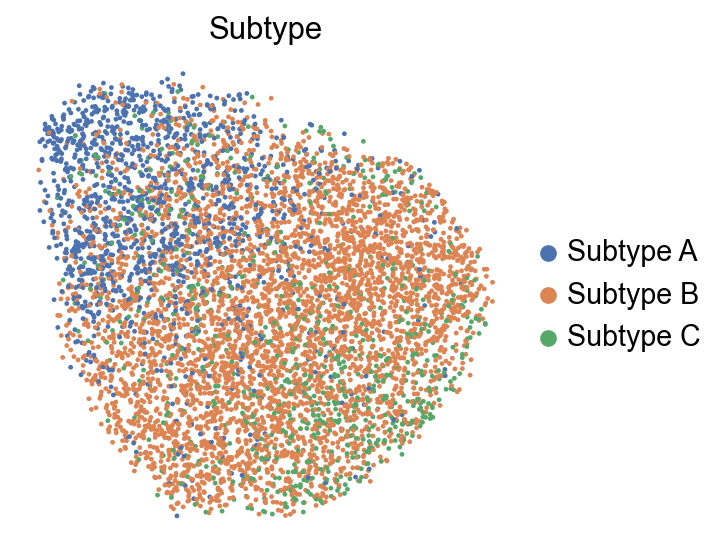

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/var/folders/lt/nhcx288j6jjfg45n3bhh1mjh0000gn/T/ipykernel_95447/558430056.py:141: MatplotlibDeprecationWarning: Unable to determine Axes to steal spa

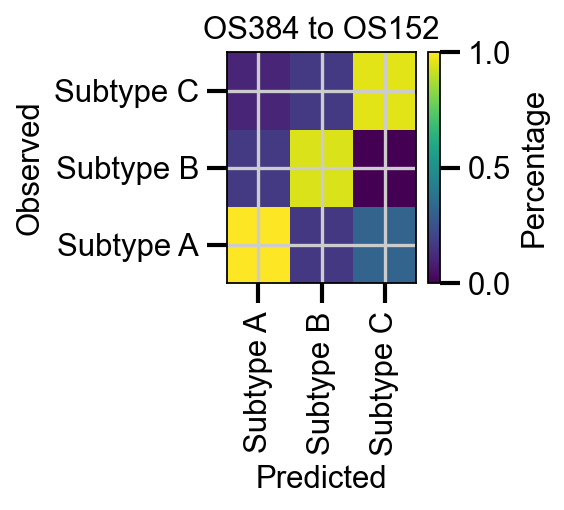

In [2]:
# setting up the scvi model
vae_384 = scvi.model.SCVI(adata_384, n_layers=2, n_latent=30, gene_likelihood="nb")

vae_384.train()

# saving the normalized expression values
adata_384.layers["scvi_normalized"] = vae_384.get_normalized_expression(
    library_size=10e4
)


# getting the latent representation
latent = vae_384.get_latent_representation()


# adding the latent variables to the adata object
adata_384.obsm["X_scVI"] = latent


# using the scVI latent space for umap generation
sc.pp.neighbors(adata_384, use_rep="X_scVI")
sc.tl.umap(adata_384, min_dist=0.3)

# clustering using the leiden algorithm
# neighbors were already computed using scVI
sc.tl.leiden(adata_384, key_added="leiden_scVI", resolution=0.58)

# plotting the clusters
sc.pl.umap(
    adata_384,
    color=["Subtype"],
    frameon=False,
)

# unlabeled category does not exist in adata.obs[labels_key]
# so all cells are treated as labeled
vae_ref_scan = scvi.model.SCANVI.from_scvi_model(
    vae_384,
    unlabeled_category= "Unknown",
    labels_key= "Subtype",
)


# Training the reference model
vae_ref_scan.train(max_epochs=20, n_samples_per_label=100)


# saving the latent representation from the reference model
adata_384.obsm["X_scANVI"] = vae_ref_scan.get_latent_representation()
sc.pp.neighbors(adata_384, use_rep="X_scANVI")
sc.tl.leiden(adata_384)
sc.tl.umap(adata_384)


# plotting the umap
sc.pl.umap(
    adata_384,
    color=["Subtype"],
    frameon=False,
    ncols=1,
)


dir_path_scan = "OS384_model_scanvi_full_152/"
vae_ref_scan.save(dir_path_scan, overwrite=True)


# preparing the query data
scvi.model.SCANVI.prepare_query_anndata(adata_152, dir_path_scan)


# loading the query data
vae_q = scvi.model.SCANVI.load_query_data(
    adata_152,
    dir_path_scan,
)


# training the query model
vae_q.train(
    max_epochs=100,
    plan_kwargs=dict(weight_decay=0.0),
    check_val_every_n_epoch=10,
)


# getting the latent representation from the query model and saving it on the adata 384 dataset
adata_152.obsm["X_scANVI"] = vae_q.get_latent_representation()


# saving the normalized expression values
adata_152.layers["scvi_normalized"] = vae_q.get_normalized_expression(
    library_size=10e4
)


# getting the latent representation
latent = vae_q.get_latent_representation()


# adding the latent variables to the adata object
adata_152.obsm["X_scVI"] = latent


# using the scVI latent space for umap generation
sc.pp.neighbors(adata_152, use_rep="X_scVI")
sc.tl.umap(adata_152, min_dist=0.3)


# clustering using the leiden algorithm
# neighbors were already computed using scVI
sc.tl.leiden(adata_152, key_added="leiden_scVI", resolution=0.6)


# plotting the clusters
sc.pl.umap(
    adata_152,
    color=["Subtype"],
    frameon=False,
)

adata_152.obs["predictions"] = vae_q.predict()

df = adata_152.obs.groupby(["Subtype", "predictions"]).size().unstack(fill_value=0)

df.head()


norm_df = df / df.sum(axis=0)

norm_df.head()

norm = mpl.colors.Normalize(vmin=0, vmax=1)

# Setting the fig size
plt.figure(figsize=(1.9, 1.9))

_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
_ = plt.colorbar(mpl.cm.ScalarMappable(norm=norm), orientation='vertical', label='Percentage')

plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title("OS384 to OS152")

# Save the plot as an SVG file
#plt.savefig('/Users/brendamelano/Desktop/OS384_OS152_scANVI.svg', format='svg')

# Show plot
plt.show()

Accuracy: 0.709245
Precision: 0.696577
Recall: 0.709245
F1 Score: 0.625559
Confusion Matrix:
[[ 317 1032    6]
 [  36 4278    4]
 [  29  780    8]]
F1 Scores by Subtype:
Subtype A: 0.364997
Subtype B: 0.822060
Subtype C: 0.019162


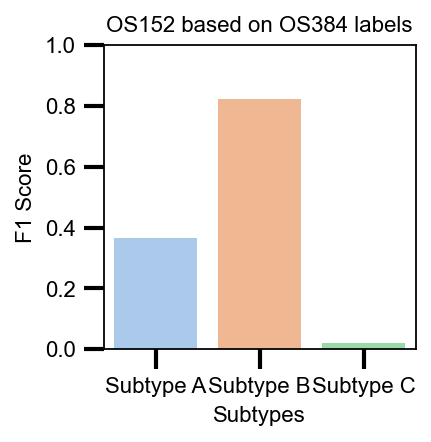

In [6]:
# F1 scores for OS384 transfer to OS152
evaluate_and_plot_f1_scores(adata_152, "OS384", "OS152", output_file='/Users/brendamelano/Desktop/f1_scores_152.svg', font_size=10)


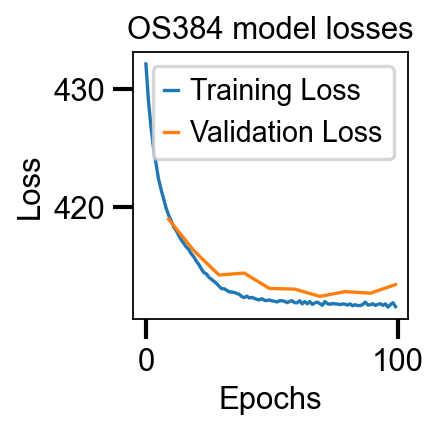

In [3]:
# F1 scores for OS152 transfer to OS384
#evaluate_and_plot_f1_scores(adata_152, "OS742", "OS152", output_file='/Users/brendamelano/Desktop/f1_scores_152_from_742.svg', font_size=10)

# Saving the training history as a separate object
training_history = vae_q.history

# Setting the fig size dimensions
plt.figure(figsize=(2.2, 2.2))


# Your existing plotting code
plt.plot(training_history['elbo_train'], label='Training Loss')
if 'elbo_validation' in training_history:
    plt.plot(training_history['elbo_validation'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('OS384 model losses')
plt.legend()

# Remove grid lines
plt.grid(False)

# Save the plot as an SVG file
plt.savefig('/Users/brendamelano/Desktop/training_history_plot.svg', format='svg')

# Show the plot
plt.show()
